In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, make_scorer, precision_score, recall_score

import shap

In [2]:
!pip install phik

In [3]:
!pip install shap

In [4]:
pip install --upgrade scikit-learn matplotlib numpy seaborn shap

  Using cached numpy-2.0.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.5 MB)
Note: you may need to restart the kernel to use updated packages.


### Введение
В проекте предстоит проанализировать характеристики пользователей и их активность, чтобы предсказать вероятность её снижения, а также разбить пользователей на группы, для привлечения каждой из которых будет придумана своя стратегия. Для этого предстоит:

1. Выполнить предобработку
2. Добавить новые признаки
3. Провести анализ зависимостей признаков
4. Выбрать модель, наиболее подходящую для решения задачи и гиперпараметры к ней
5. Проанализировать вклад каждого признака на целевой
6. Разделить пользователей на сегменты и продумать стратегию для каждого

## Загрузка данных


In [5]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money =  pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

In [6]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [7]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [8]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [9]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


## Предобработка данных

In [10]:
df_list = [market_file, market_money, market_time, money]

In [11]:
for i in df_list:
    print(i.info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Типы данных в порядке, пропусков нет. Изменим названия признаков

In [12]:
def rename_col(df):
        df.columns = df.columns.str.lower()
        df.columns = df.columns.str.replace(' ', '_')

In [13]:
rename_col(market_file)
rename_col(market_money)
rename_col(market_time)
rename_col(money)

Проверим дубликаты

In [14]:
for i in df_list:
    print(i.duplicated().sum())

0
0
0
0


In [15]:
for i in df_list:
    for j in i.select_dtypes('object'):
        print(j, i[j].unique(), '\n')
    

покупательская_активность ['Снизилась' 'Прежний уровень'] 

тип_сервиса ['премиум' 'стандартт' 'стандарт'] 

разрешить_сообщать ['да' 'нет'] 

популярная_категория ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника'] 

период ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц'] 

период ['текущий_месяц' 'предыдцщий_месяц'] 



Есть ошибка в признаке 'тип_сервиса' и 'период'

In [16]:
market_file.loc[market_file['тип_сервиса'] == 'стандартт', 'тип_сервиса'] = 'стандарт'

In [17]:
market_time.loc[market_time['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц'

## Исследовательский анализ данных

In [18]:
for i in df_list:
    display(i.describe())

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


,id,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Замечен выброс в признаке 'выручка'

#### Построим графики 

In [19]:
def num_hist(df, lst):
    for i in lst:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
        
        df[i].plot(kind='hist', bins=15, ax=axes[0])
        axes[0].set_title(f'Гистограмма {df[i].name}')
        axes[0].set_xlabel(df[i].name)
        axes[0].set_ylabel('Частота')

        df[i].plot(kind='box', ax=axes[1])
        axes[1].set_title(f'Boxplot {df[i].name}')
        
        plt.tight_layout()
        plt.show()

In [20]:
def cat_bar(df, lst):
     for i in lst:
        plt.figure()
        df[i].value_counts().plot(kind='bar')
        plt.title(df[i].name)
        plt.xlabel(df[i].name)
        plt.ylabel('Частота')
        plt.show()

In [21]:
market_file_num = market_file.select_dtypes(exclude='object').columns
market_file_cat = market_file.select_dtypes('object').columns
market_money_num = market_money.select_dtypes(exclude='object').columns
market_money_cat = market_money.select_dtypes('object').columns
market_time_num = market_time.select_dtypes(exclude='object').columns
market_time_cat = market_time.select_dtypes('object').columns
money_num = money.select_dtypes(exclude='object').columns
money_cat = money.select_dtypes('object').columns

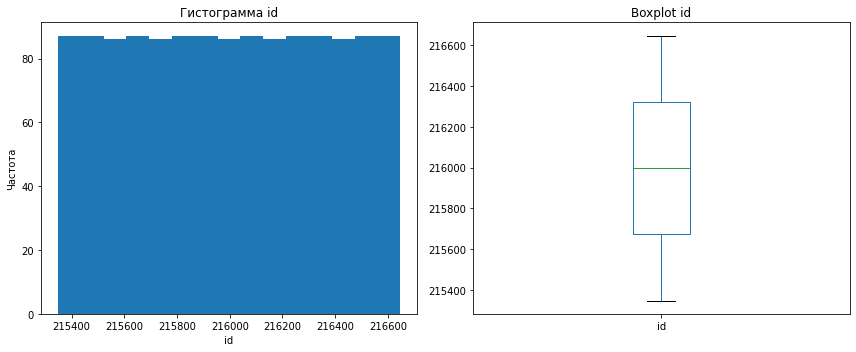

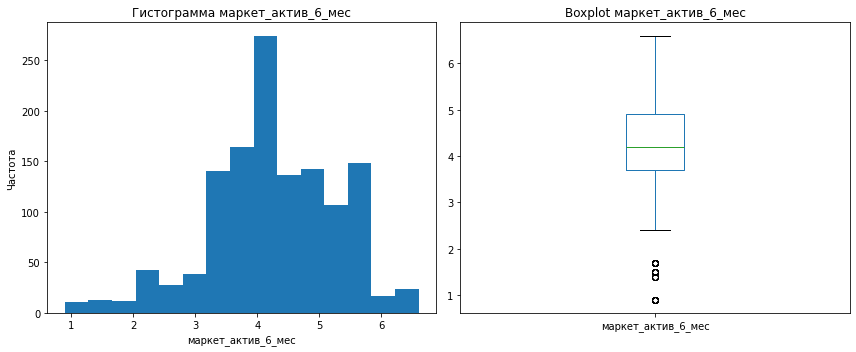

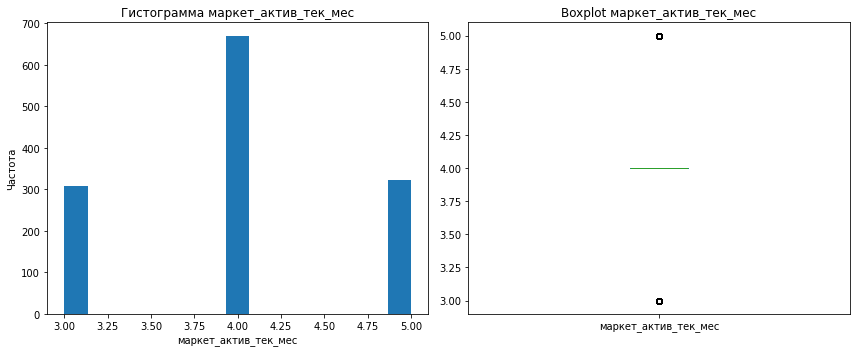

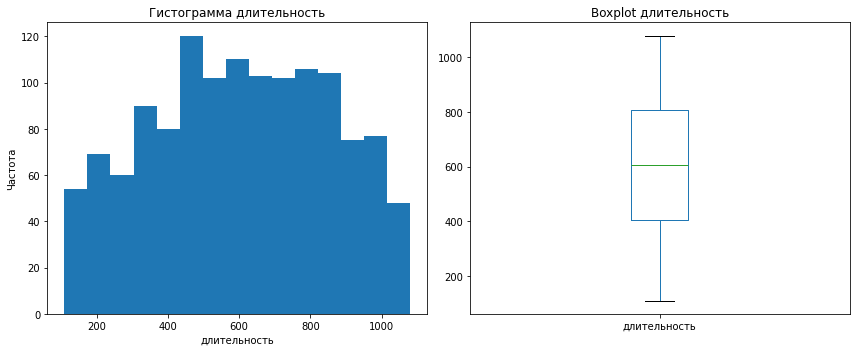

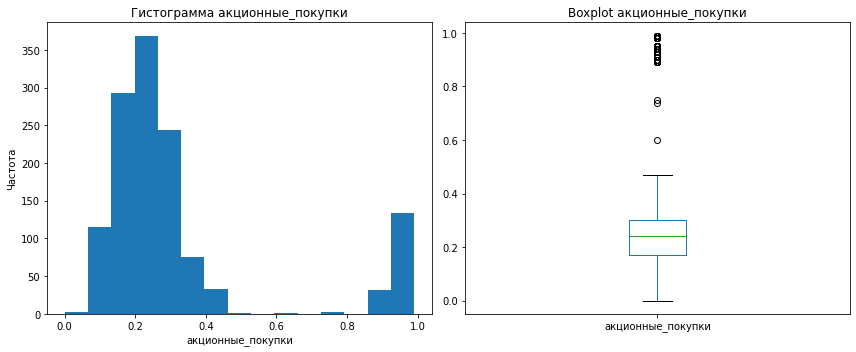

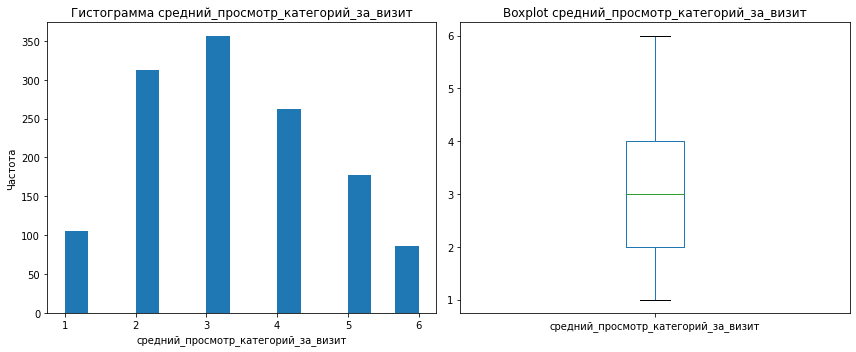

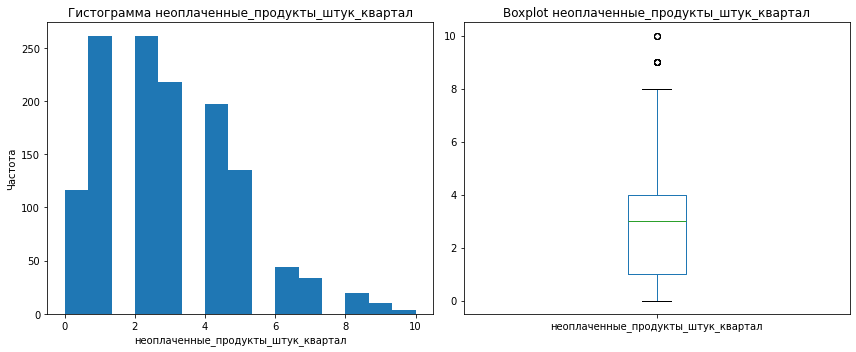

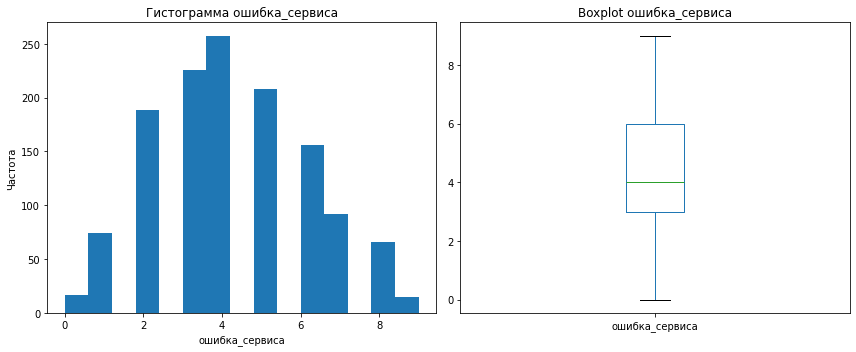

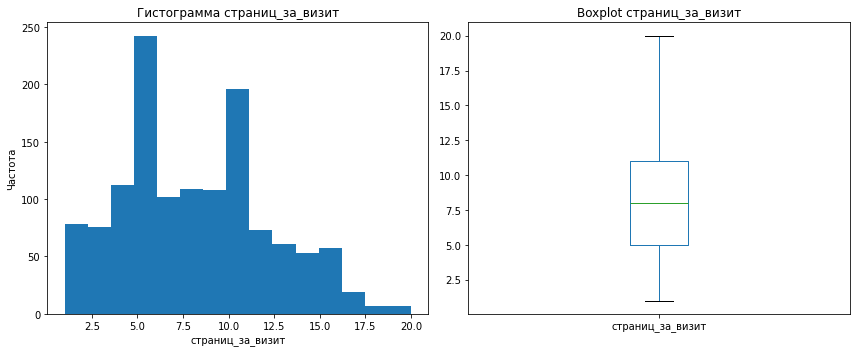

In [22]:
num_hist(market_file, market_file_num)

Нормальное распределение имеет. только признак 'ошибка_сервиса', выбросов нет

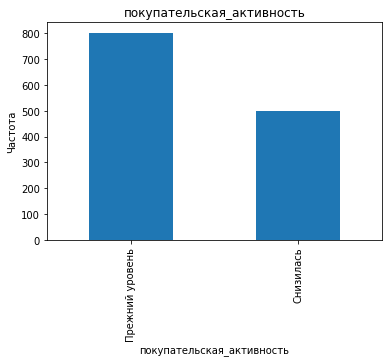

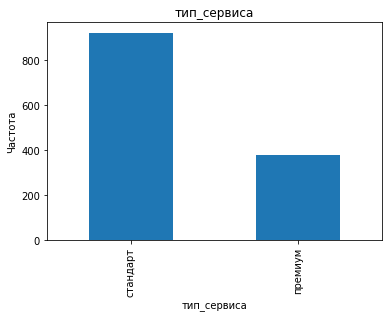

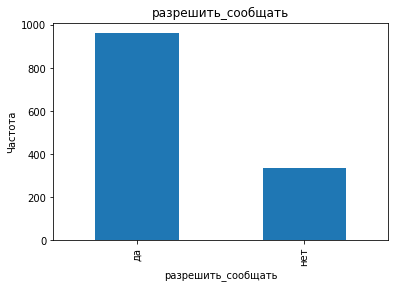

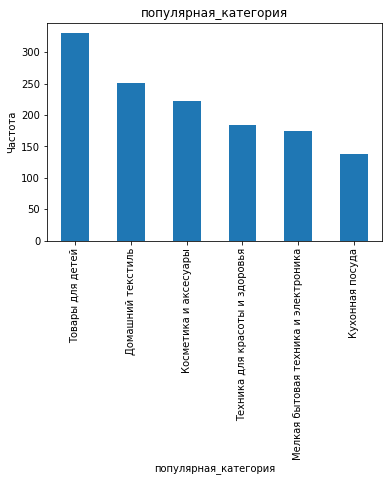

In [23]:
cat_bar(market_file, market_file_cat)

В целевой переменной имеется небольшой дисбаланс классов

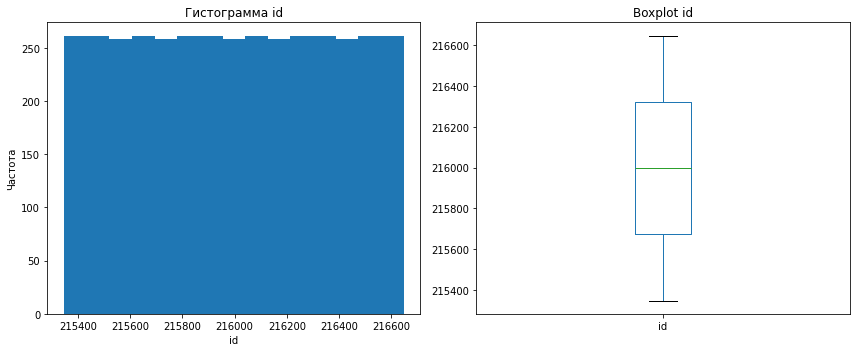

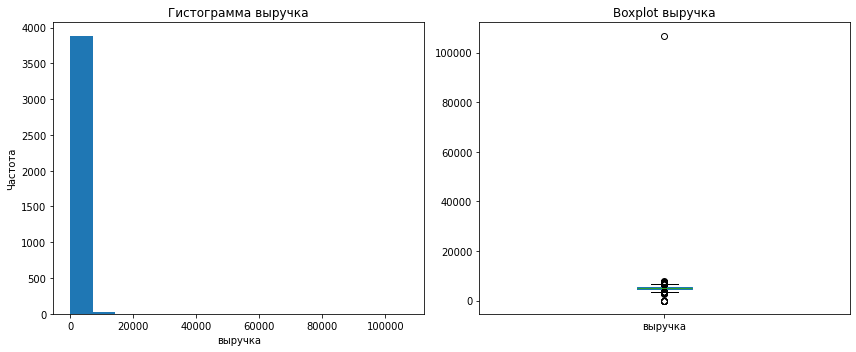

In [24]:
num_hist(market_money, market_money_num)

Удалим выброс в выручке

In [25]:
market_money = market_money.query('выручка < 80000')

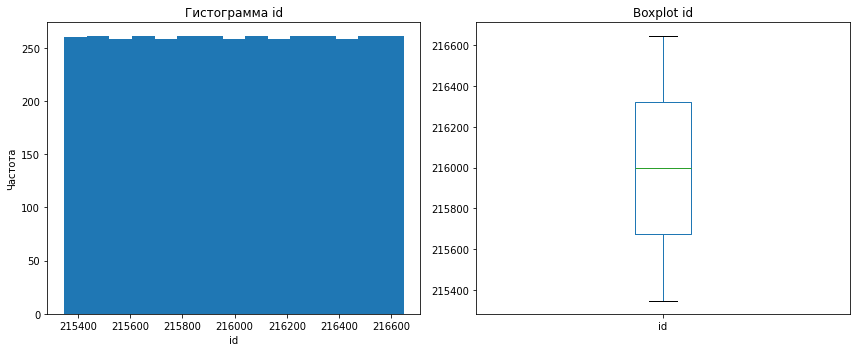

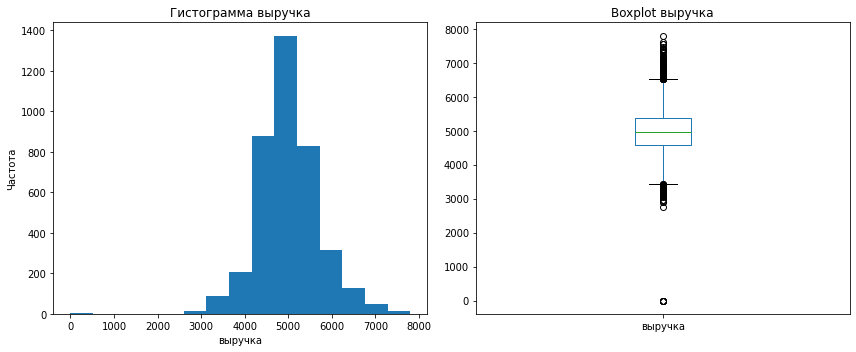

In [26]:
num_hist(market_money, market_money_num)

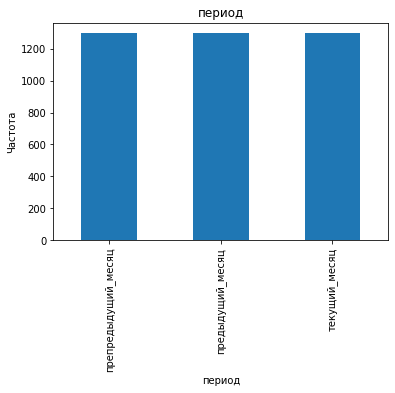

In [27]:
cat_bar(market_money, market_money_cat)

Периоды распределены равномерно

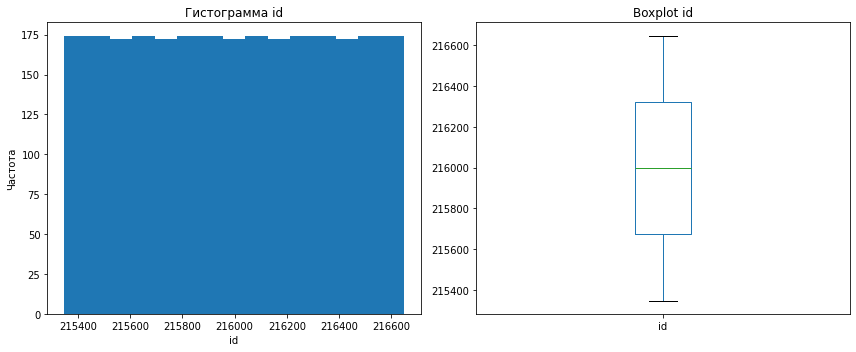

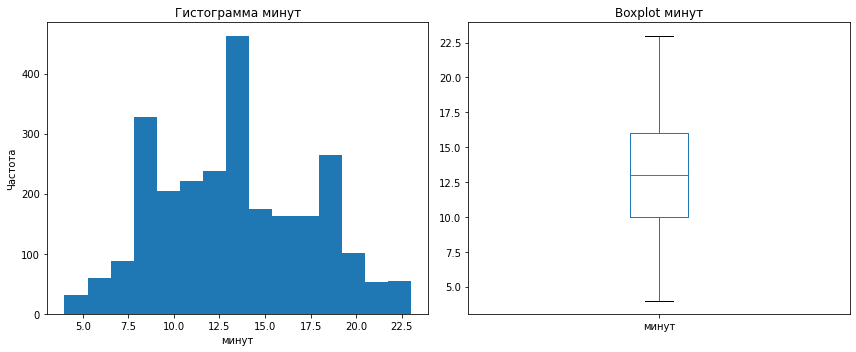

In [28]:
num_hist(market_time, market_time_num)

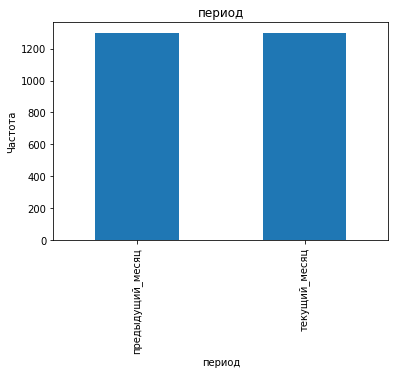

In [29]:
cat_bar(market_time, market_time_cat)

Периоды распределены равномерно

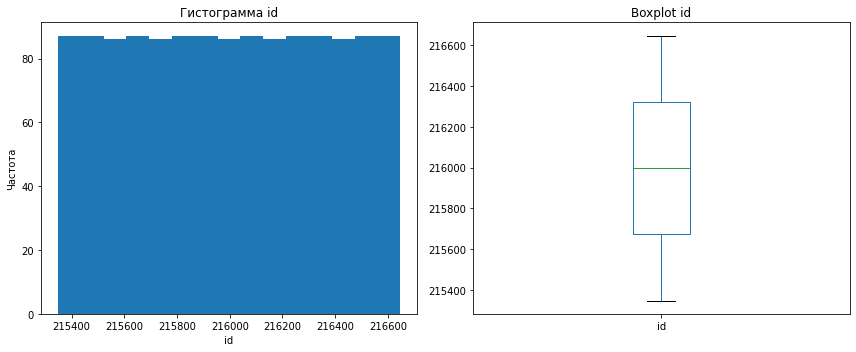

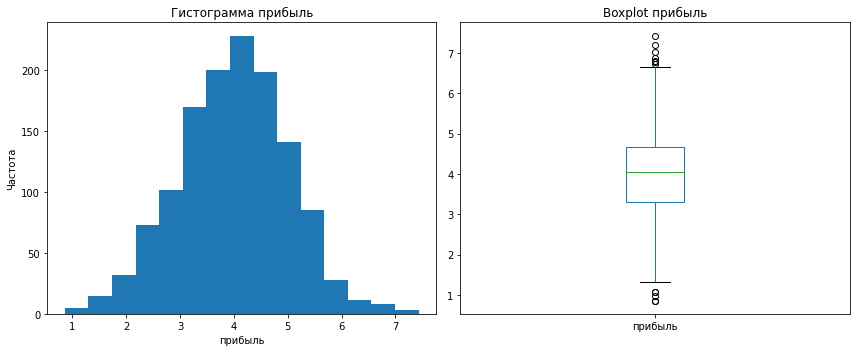

In [30]:
num_hist(money, money_num)

Прибыль имеет нормальное распределение. Аномалий нет

## Объединение таблиц

Просуммируем занчения в market_money и market_time для одинаковых id и присоединим к market_file по id

In [31]:
df = market_file.\
merge(market_money.query('период == "препредыдущий_месяц"').pivot_table(index='id', 
                                                                      values='выручка', aggfunc='sum').reset_index().\
     rename(columns={'выручка': 'выручка_препред'}))
df = df.\
merge(market_money.query('период == "предыдущий_месяц"').pivot_table(index='id', 
                                                                      values='выручка', aggfunc='sum').reset_index().\
     rename(columns={'выручка': 'выручка_пред'}))
df = df.\
merge(market_money.query('период == "текущий_месяц"').pivot_table(index='id', 
                                                                      values='выручка', aggfunc='sum').reset_index().\
     rename(columns={'выручка': 'выручка_текущий'}))
df = df.\
merge(market_time.query('период == "предыдущий_месяц"').pivot_table(index='id', 
                                                                      values='минут', aggfunc='sum').reset_index().\
     rename(columns={'минут': 'минут_пред'}))
df = df.\
merge(market_time.query('период == "текущий_месяц"').pivot_table(index='id', 
                                                                      values='минут', aggfunc='sum').reset_index().\
     rename(columns={'минут': 'минут_текущий'}))

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



 

- правильно что использован pivot_table,  наверное самый оптимальный метод для  задачи что то повернуть


 

In [32]:
df.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препред,выручка_пред,выручка_текущий,минут_пред,минут_текущий
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11


Удалим из данных пользователей, которые не совершали покупки ни в одном из месяцев

In [33]:
df = df.query('выручка_препред != 0 and выручка_текущий !=0 and выручка_пред != 0')

## Корреляционный анализ

In [34]:
cor = df.drop('id', axis=1).corr(method='spearman')

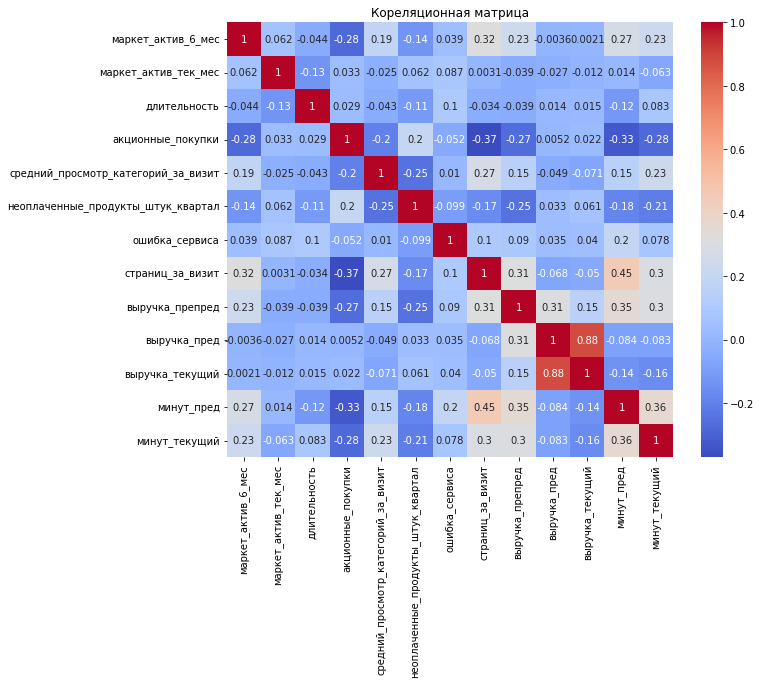

In [35]:
plt.figure(figsize=(10, 8))
sns.heatmap(cor, annot=True, cmap='coolwarm');
plt.title('Кореляционная матрица')
plt.show()

Построим матрицы отдельно для пользователей со снижающейся и с прежней активностью

In [36]:
cor_lower = df.drop('id', axis=1).query('покупательская_активность == "Снизилась"').corr(method='spearman')

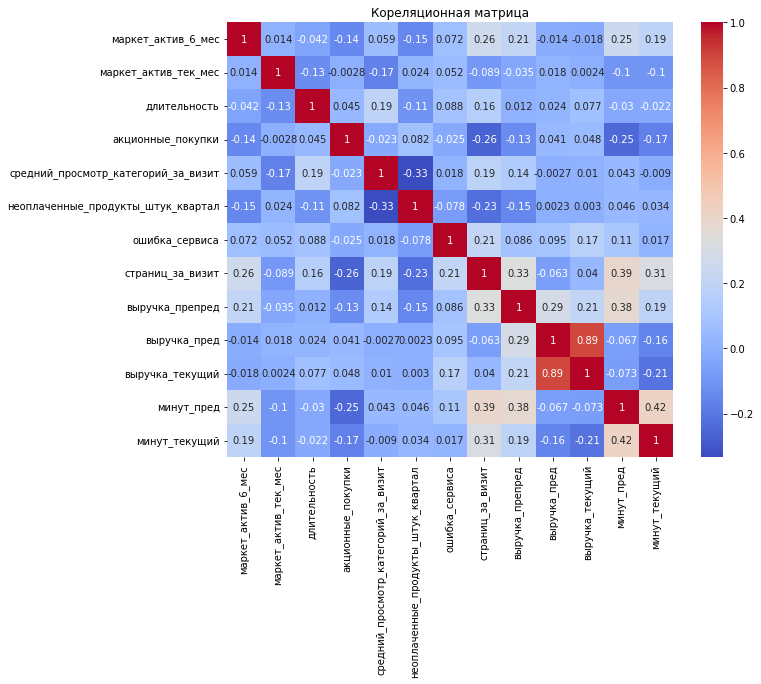

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(cor_lower, annot=True, cmap='coolwarm');
plt.title('Кореляционная матрица')
plt.show()

In [38]:
cor_stable = df.drop('id', axis=1).query('покупательская_активность != "Снизилась"').corr(method='spearman')

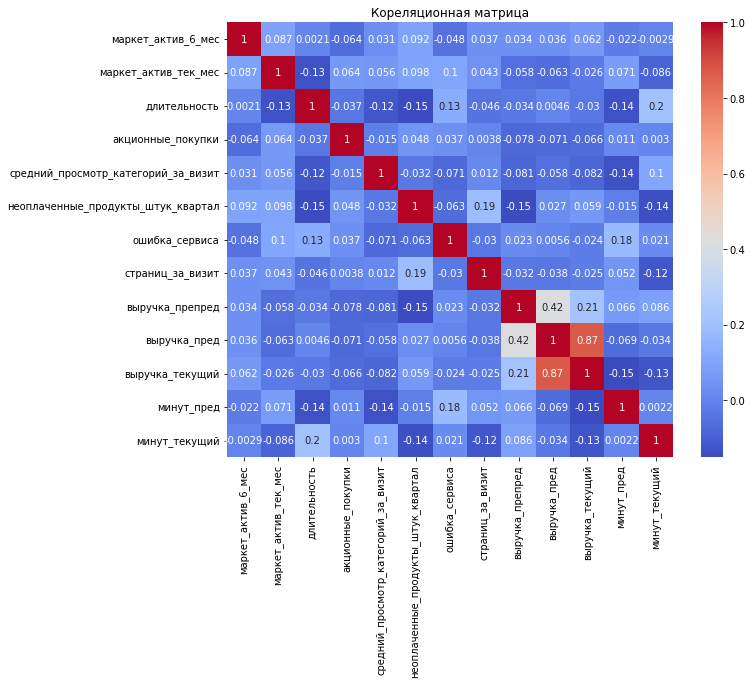

In [39]:
plt.figure(figsize=(10, 8))
sns.heatmap(cor_stable, annot=True, cmap='coolwarm');
plt.title('Кореляционная матрица')
plt.show()

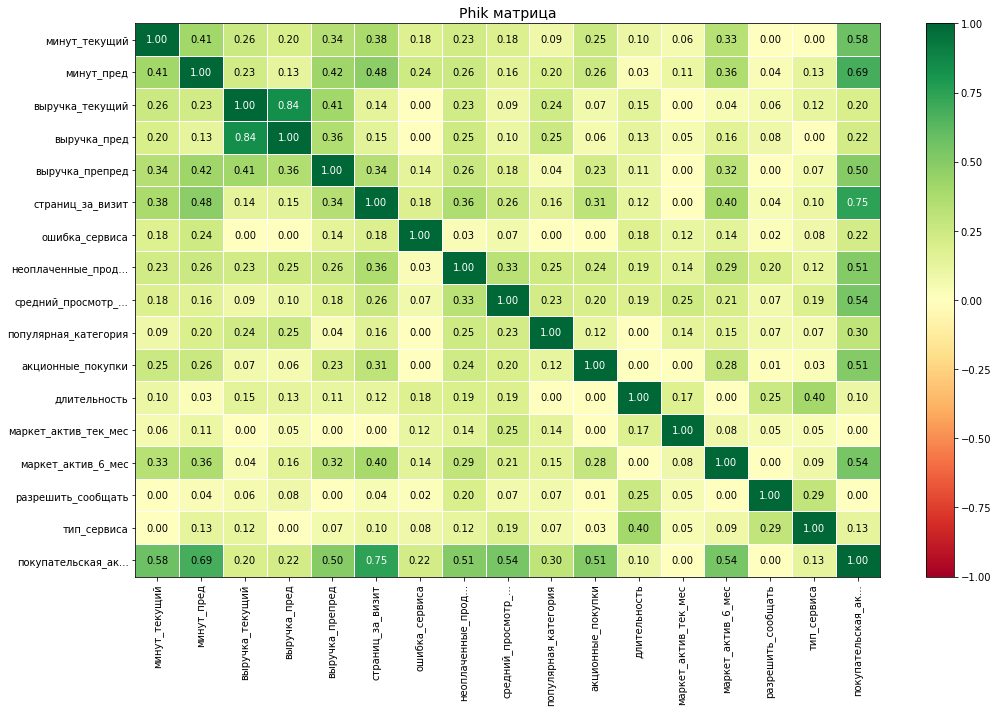

In [40]:
phik_matrix = df.drop('id', axis=1).phik_matrix(interval_cols=df.drop('id', axis=1).select_dtypes(exclude='object').columns)

plot_correlation_matrix(phik_matrix.values, 
                        x_labels=phik_matrix.columns, 
                        y_labels=phik_matrix.index, 
                        vmin=-1, vmax=1, title="Phik матрица", figsize=(15, 10))

plt.show()

За исключением выручки и минут в разные периоды, значительной зависимости между признаками не наблюдается. Мультиколлинеарности нет

## Использование пайплайнов

Сначала разделим выборку

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['покупательская_активность', 'id'], axis=1),
    df['покупательская_активность'],
    test_size = 0.2, 
    random_state = 42,
    stratify = df['покупательская_активность'])

In [42]:
for i in df.select_dtypes('object'):
    print(i, df[i].unique())

покупательская_активность ['Снизилась' 'Прежний уровень']
тип_сервиса ['премиум' 'стандарт']
разрешить_сообщать ['да' 'нет']
популярная_категория ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Кухонная посуда' 'Техника для красоты и здоровья'
 'Мелкая бытовая техника и электроника']


In [43]:
ohe_columns = ['разрешить_сообщать', 'популярная_категория']
ord_columns = ['тип_сервиса']
num_columns = X_train.select_dtypes(exclude='object').columns

Создадим пайплайны

In [44]:
ohe_pipe = Pipeline(
    [
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )

ord_pipe = Pipeline(
    [
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        )
    ]
)

In [45]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [46]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=42))
])

In [47]:
param_distributions = [
    {
        'preprocessor__num': [MinMaxScaler(), StandardScaler()],
        'models': [LogisticRegression(random_state=42)],
        'models__C': [0.01, 0.1, 1, 10], 
        'models__penalty': ['l1', 'l2'],
        'models__solver': ['liblinear']
    },
    {
        'preprocessor__num': [MinMaxScaler(), StandardScaler()],
        'models': [DecisionTreeClassifier(random_state=42)],
        'models__max_depth': range(2, 12),
        'models__min_samples_split': range(2, 10)
    },
    {
        'preprocessor__num': [MinMaxScaler(), StandardScaler()],
        'models': [SVC()],
        'models__C': [0.01, 0.1, 1, 10],  
        'models__kernel': ['linear', 'rbf'],
    },
     {
        'preprocessor__num': [MinMaxScaler(), StandardScaler()],
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': [2, 3, 5, 10, 100],  
    }
]

In [48]:
recall_scorer = make_scorer(recall_score, pos_label='Снизилась')

In [49]:
random_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions,
    n_iter=200, 
    cv=5, 
    scoring=recall_scorer, 
    n_jobs=-1, 
    random_state=35
)

In [50]:
%%time
random_search.fit(X_train, y_train)

CPU times: user 23.1 s, sys: 267 ms, total: 23.3 s
Wall time: 23.4 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['разрешить_сообщать',
                                                                                'популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(categories=[['стандарт',
                                                                                                                            'премиум']],
                                                                                                               handle_unknown=...
                                        {'models': [SVC()],
                                         'models__C': [0.01, 0.1, 1, 10],
                                         'models__kernel': ['linear', 'rbf'],
                                         'preprocessor__num': [MinMaxScaler(),
                                                               StandardScaler()]},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': [2, 3, 5, 10,
                                                                 100],
                                         'preprocessor__num': [MinMaxScaler(),
                                                               StandardScaler()]}],
                   random_state=35,
                   scoring=make_scorer(recall_score, response_method='predict', pos_label=Снизилась))

In [51]:
random_search.classes_

array(['Прежний уровень', 'Снизилась'], dtype=object)

In [52]:
random_search.best_params_

{'preprocessor__num': StandardScaler(),
 'models__solver': 'liblinear',
 'models__penalty': 'l1',
 'models__C': 0.01,
 'models': LogisticRegression(random_state=42)}

In [53]:
f'Метрика roc_auc у лучшей модели - {random_search.best_score_}'

'Метрика roc_auc у лучшей модели - 0.8177215189873419'

Лучше всего себя показала модель логистической регрессии с l1 регуляризацией и параметром C, равным 0.01

In [54]:
model = random_search.best_estimator_.named_steps['models']

In [55]:
X_test_transformed = random_search.best_estimator_.named_steps['preprocessor'].transform(X_test)

In [56]:
y_pred = model.predict(X_test_transformed)

In [57]:
accuracy_score(y_test, y_pred)

0.8692307692307693

In [58]:
recall_score(y_test, y_pred, pos_label='Снизилась')

0.8484848484848485

Метрики хорошие

## Анализ важности признаков

Построим график SHAP

In [59]:
feature_names = random_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
feature_names

array(['ohe__разрешить_сообщать_нет',
       'ohe__популярная_категория_Косметика и аксесуары',
       'ohe__популярная_категория_Кухонная посуда',
       'ohe__популярная_категория_Мелкая бытовая техника и электроника',
       'ohe__популярная_категория_Техника для красоты и здоровья',
       'ohe__популярная_категория_Товары для детей', 'ord__тип_сервиса',
       'num__маркет_актив_6_мес', 'num__маркет_актив_тек_мес',
       'num__длительность', 'num__акционные_покупки',
       'num__средний_просмотр_категорий_за_визит',
       'num__неоплаченные_продукты_штук_квартал', 'num__ошибка_сервиса',
       'num__страниц_за_визит', 'num__выручка_препред',
       'num__выручка_пред', 'num__выручка_текущий', 'num__минут_пред',
       'num__минут_текущий'], dtype=object)

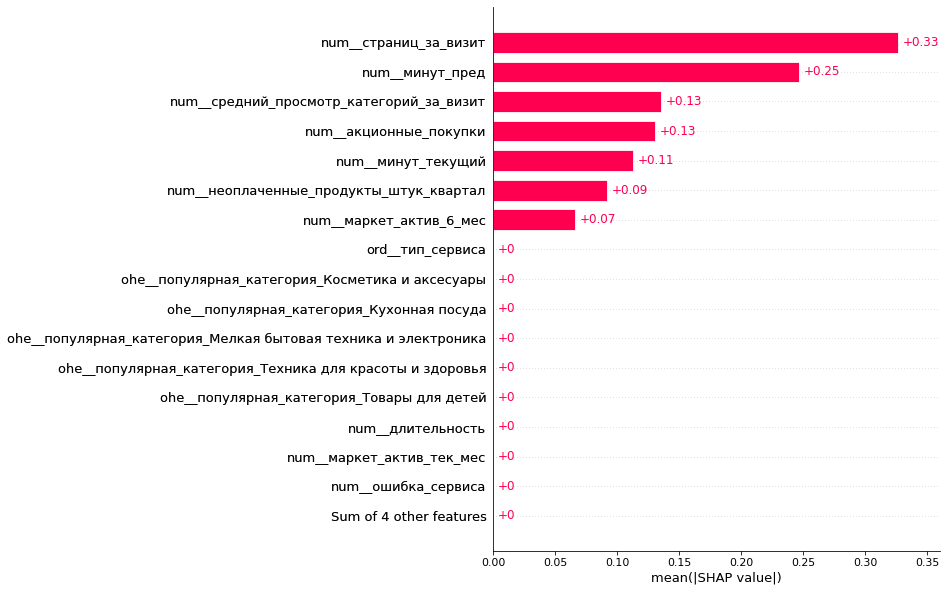

In [60]:
explainer = shap.LinearExplainer(model, X_test_transformed, feature_names=feature_names)
shap_values = explainer(X_test_transformed)
shap.plots.bar(shap_values, max_display=17)

Наибольшее влияние имеют признаки "страниц за визит", "средний_просмотр_категорий_за_визит" и "минут". Нулевое влияние имеют выручка за текущий месяц, "маркет_актив" за текущий месяц и "разрешить_сообщать", а также категориальные признаки

1. Можно сделать вывод, что маркетинговая активность в последний месяц перестала влиять на пользовательскую, поэтому имеет смысл пересмотреть стратегию
2. Больше всего на пользовательскую влияют факторы, задерживающие их на сайте. Можно улучшить рекомендательную систему, что поможет повышать активность

## Сегментация покупателей

Добавим новые столбцы, по которым будут составляться категории: вероятность снижения активности и прибыль

In [61]:
model.classes_

array(['Прежний уровень', 'Снизилась'], dtype=object)

In [62]:
df_transformed = random_search.best_estimator_.named_steps['preprocessor'].\
transform(df.drop(['id', 'покупательская_активность'], axis=1))

In [63]:
proba = model.predict_proba(df_transformed)

In [64]:
df['вероятность_снижения_активности'] = proba[:, 1]

In [65]:
df = df.merge(money)

In [66]:
df.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препред,выручка_пред,выручка_текущий,минут_пред,минут_текущий,вероятность_снижения_активности,прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10,0.679378,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13,0.558010,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13,0.680300,4.87
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11,0.803271,4.21
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10,0.633287,3.95


In [67]:
def num_hist_group(df1, df2, lst):
    for i in lst:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
        
        df1[i].plot(kind='hist', bins=15, ax=axes[0], alpha=0.7)
        axes[0].set_title(f'Гистограмма {df1[i].name} группы')
        axes[0].set_xlabel(df1[i].name)
        axes[0].set_ylabel('Частота')

        df2[i].plot(kind='hist', bins=15, ax=axes[1], alpha=0.7)
        axes[1].set_title(f'Гистограмма {df2[i].name}')
        axes[1].set_xlabel(df2[i].name)
        axes[1].set_ylabel('Частота')
        
        plt.tight_layout()
        plt.show()

In [74]:


def cat_bar_group(df1, df2, lst):
    for i in lst:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
        
        df1[i].value_counts().plot(kind='bar', ax=axes[0])
        axes[0].set_title(f'{df1[i].name} группы')
        axes[0].set_xlabel(df1[i].name)
        axes[0].set_ylabel('Частота')

        df2[i].value_counts().plot(kind='bar', ax=axes[1])
        axes[1].set_title(f'общий {df2[i].name}')
        axes[1].set_xlabel(df2[i].name)
        axes[1].set_ylabel('Частота')
        
        plt.tight_layout()
        plt.show()


Выделим сегменты
1. Группа клиентов с высокой долей покупок по акции и высокой вероятностью снижения покупательской активности.



In [75]:
group1 = df.query('акционные_покупки > 0.85 and вероятность_снижения_активности > 0.7')

In [76]:
group1.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препред,выручка_пред,выручка_текущий,минут_пред,минут_текущий,вероятность_снижения_активности,прибыль
count,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.00000,110.000000,110.000000,110.000000
mean,215550.500000,3.423636,3.945455,600.772727,0.943000,2.472727,4.318182,3.909091,3.963636,4604.900000,4936.995455,5247.258182,9.70000,9.927273,0.806327,3.888818
std,121.451825,1.040195,0.675065,218.622193,0.034122,1.114616,2.441731,1.825133,1.579265,215.884396,843.491231,896.398937,2.32872,2.325405,0.047384,0.915443
min,215352.000000,0.900000,3.000000,167.000000,0.890000,1.000000,0.000000,1.000000,1.000000,4098.000000,3146.000000,3232.200000,5.00000,4.000000,0.701775,1.630000
25%,215449.000000,3.000000,3.250000,458.000000,0.930000,2.000000,3.000000,3.000000,3.000000,4443.250000,4401.250000,4611.025000,8.00000,8.000000,0.776296,3.245000
50%,215535.500000,3.800000,4.000000,600.000000,0.940000,2.000000,4.000000,3.500000,4.000000,4626.000000,5072.000000,5250.900000,10.00000,10.000000,0.810469,4.010000
75%,215644.750000,4.100000,4.000000,778.250000,0.980000,3.000000,6.000000,5.000000,5.000000,4770.000000,5563.125000,5778.375000,11.00000,11.000000,0.839302,4.427500
max,215910.000000,5.600000,5.000000,1064.000000,0.990000,6.000000,10.000000,8.000000,8.000000,4990.000000,6716.500000,7799.400000,16.00000,17.000000,0.901797,6.730000


In [77]:
df_num = df.select_dtypes(exclude='object')
df_cat = df.select_dtypes('object')

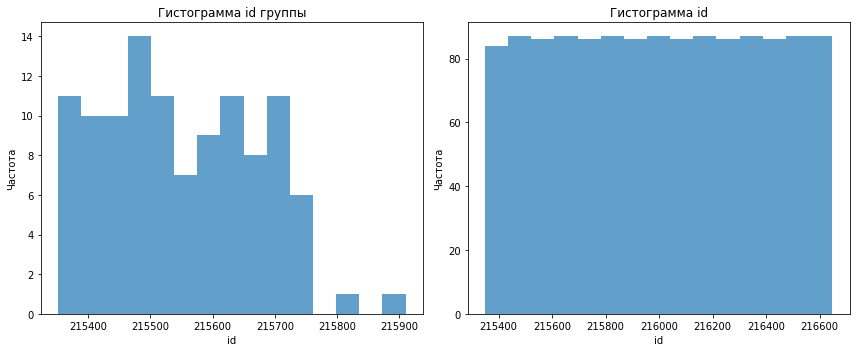

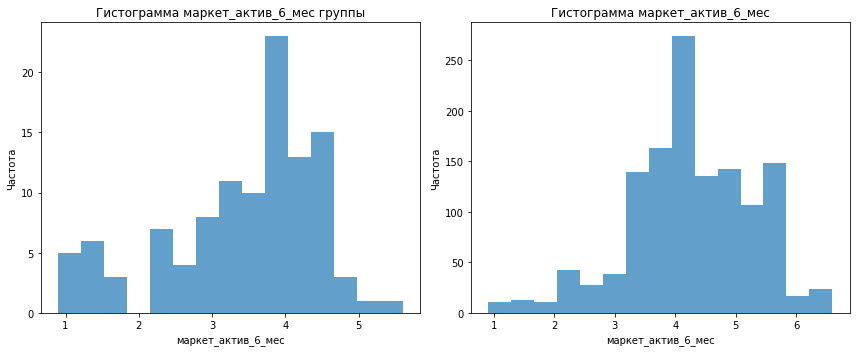

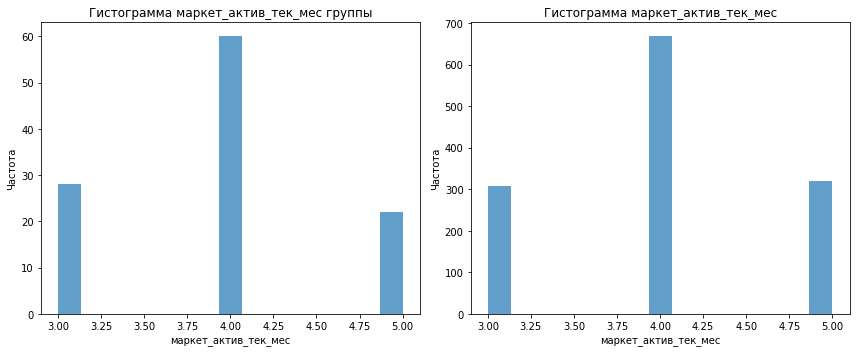

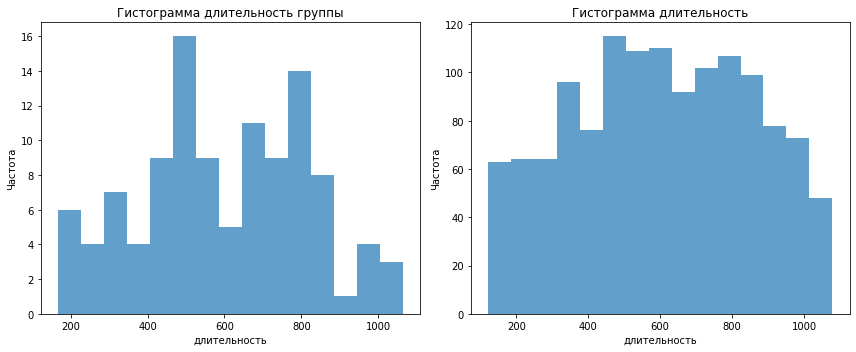

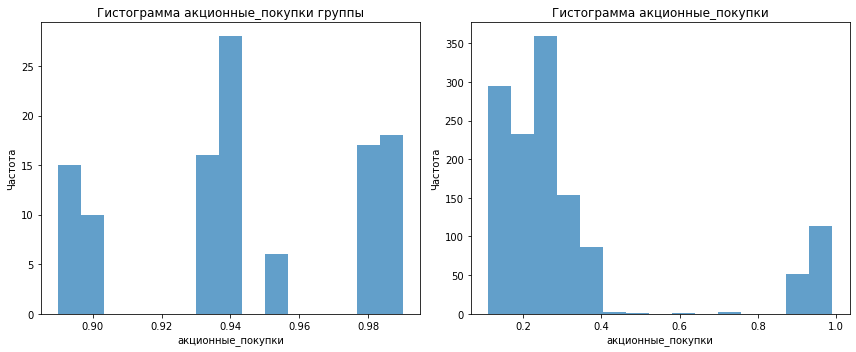

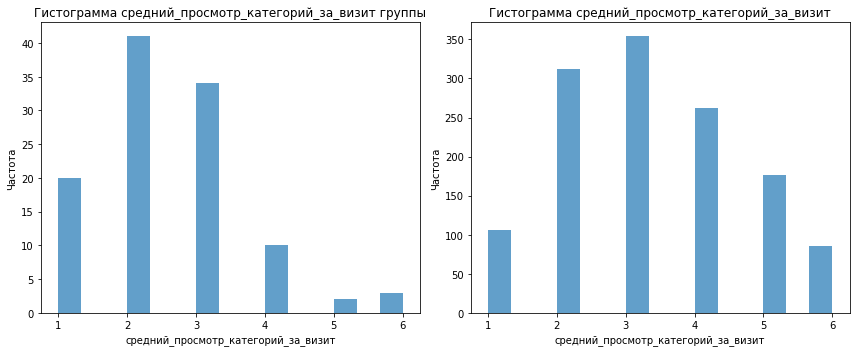

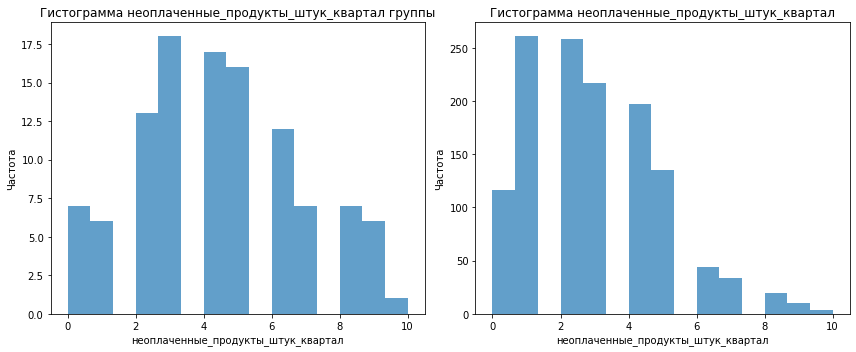

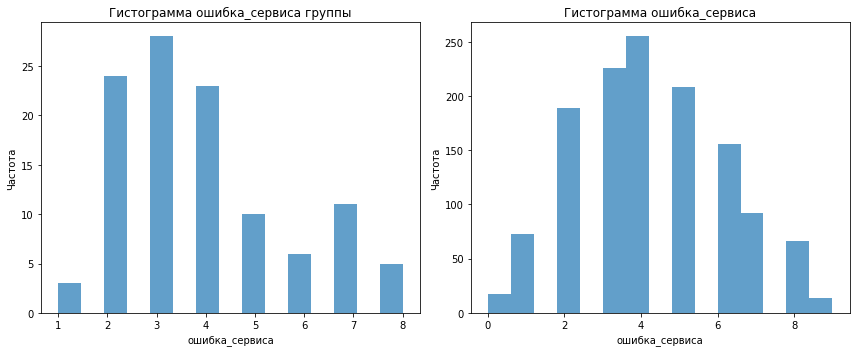

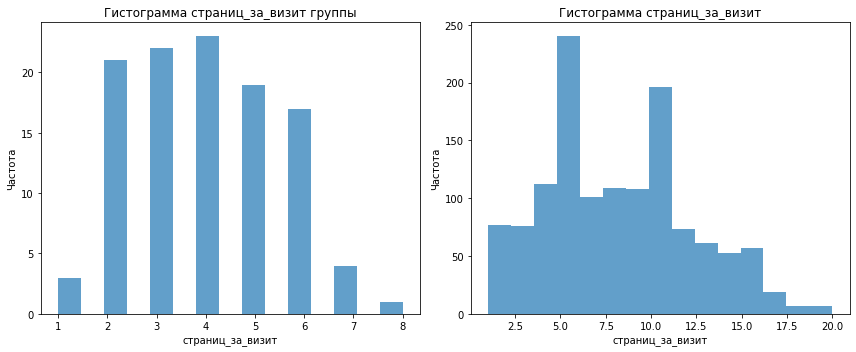

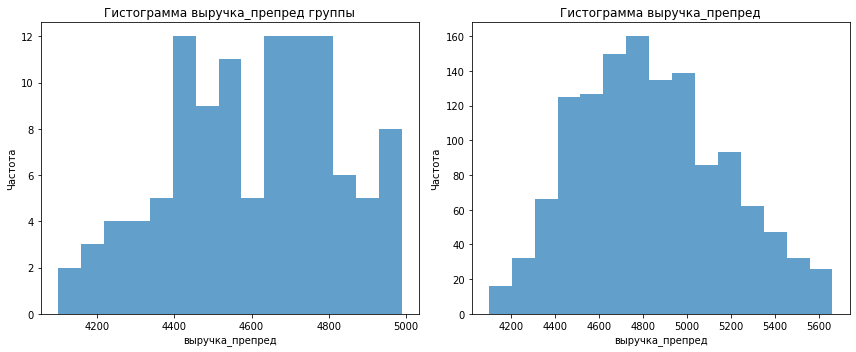

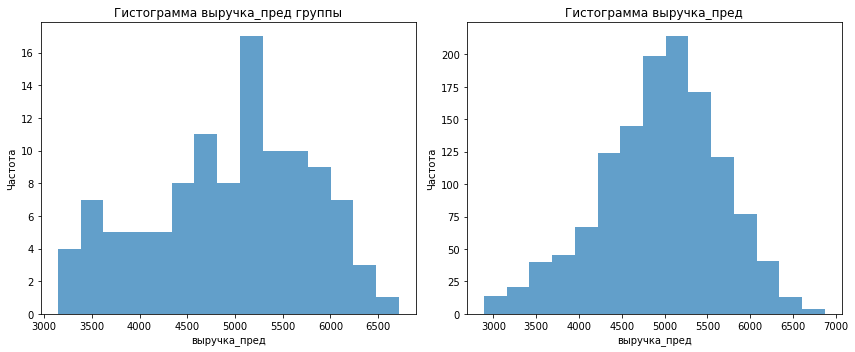

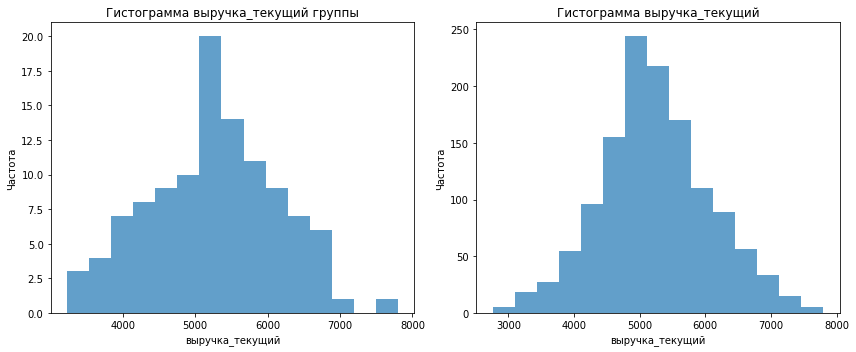

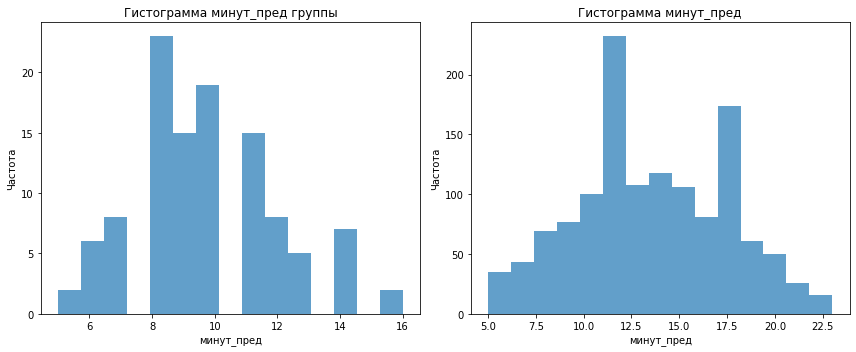

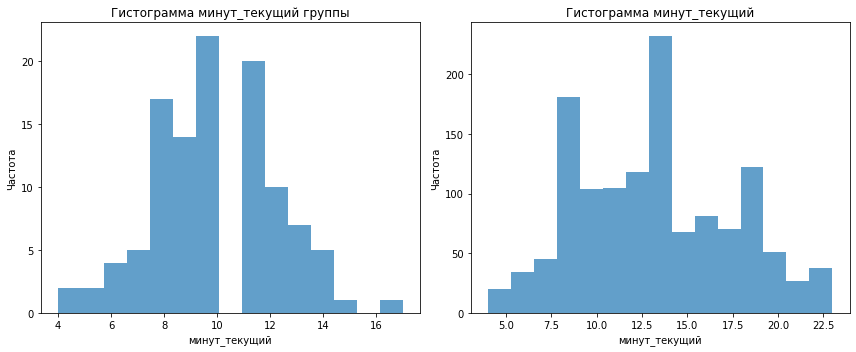

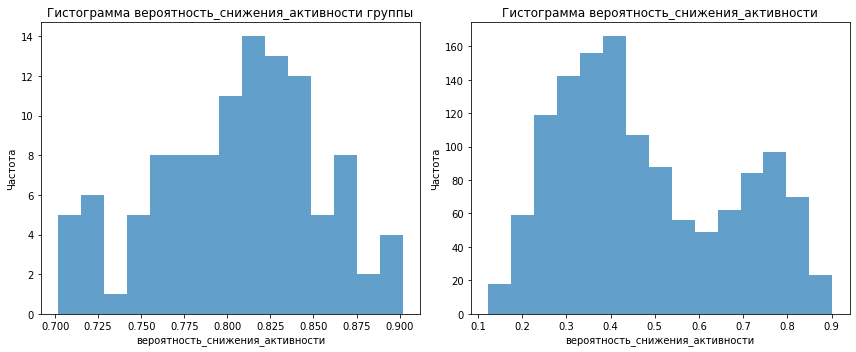

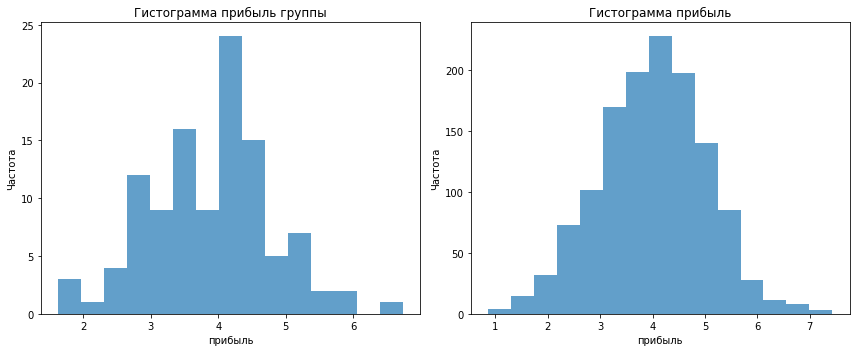

In [78]:
num_hist_group(group1, df, df_num)

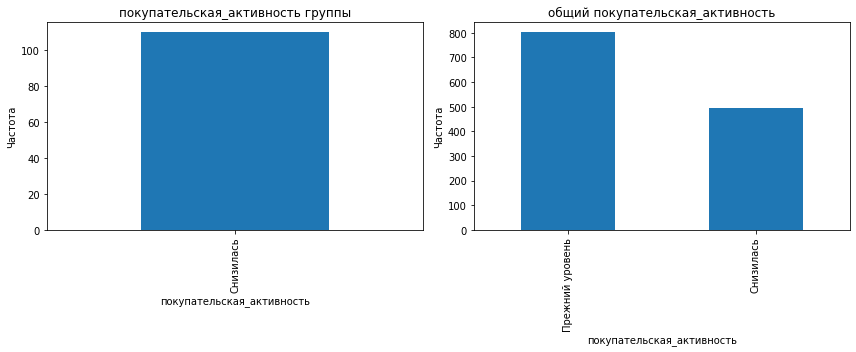

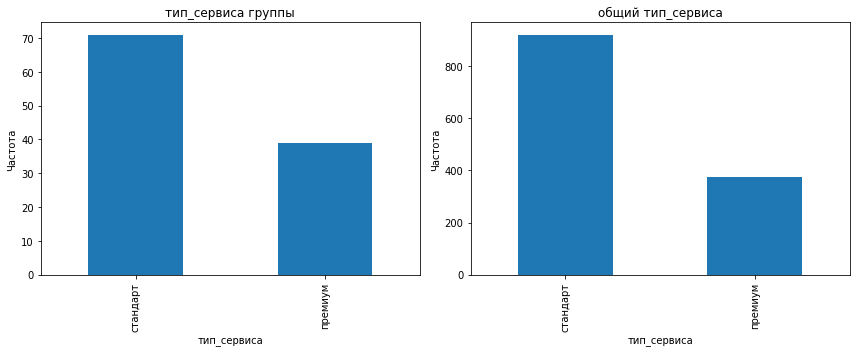

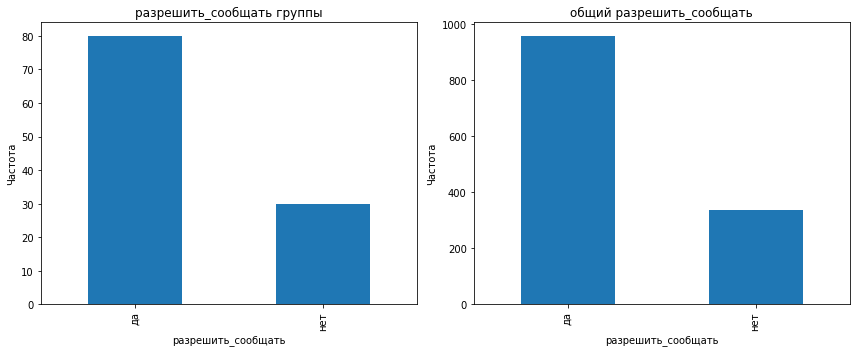

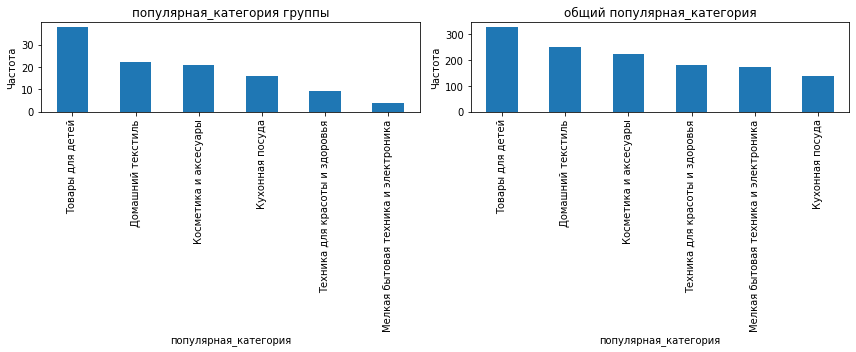

In [79]:
cat_bar_group(group1, df, df_cat)

Можно заметить, что пользователи группы просматривают меньше страниц и товаров, когда пользуютя сайтом. Завлечь их можно с помощью увеличения интересного предложения, например, в категории "товары для детей", так как она является самой популярной у группы

2. Группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.

In [80]:
group2 = df.query('популярная_категория == "Техника для красоты и здоровья"')

In [81]:
group2.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препред,выручка_пред,выручка_текущий,минут_пред,минут_текущий,вероятность_снижения_активности,прибыль
count,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.00000,182.000000,182.000000,182.000000
mean,216072.203297,4.351648,4.027473,601.395604,0.315659,3.318681,2.626374,4.258242,8.906593,4837.637363,4660.851648,4984.795055,14.21978,13.708791,0.441365,3.793626
std,357.424624,0.956844,0.700681,258.265993,0.255761,1.361500,2.208213,2.006705,3.775036,323.328341,781.797149,632.111960,3.21702,4.179380,0.168320,1.086249
min,215361.000000,0.900000,3.000000,129.000000,0.110000,1.000000,0.000000,0.000000,1.000000,4165.000000,2890.000000,2758.700000,6.00000,4.000000,0.164582,0.860000
25%,215825.750000,3.900000,4.000000,384.750000,0.160000,2.000000,1.000000,3.000000,6.000000,4590.500000,4075.750000,4638.050000,12.00000,10.250000,0.303926,3.035000
50%,216074.000000,4.300000,4.000000,621.000000,0.240000,3.000000,2.000000,4.000000,9.000000,4823.000000,4722.500000,4984.050000,14.00000,14.000000,0.403936,3.770000
75%,216367.500000,4.900000,5.000000,826.750000,0.300000,4.000000,3.000000,6.000000,11.000000,5037.000000,5232.250000,5310.100000,16.00000,16.750000,0.550148,4.520000
max,216647.000000,6.600000,5.000000,1072.000000,0.990000,6.000000,10.000000,9.000000,19.000000,5600.000000,6531.000000,7338.200000,22.00000,22.000000,0.850774,6.590000


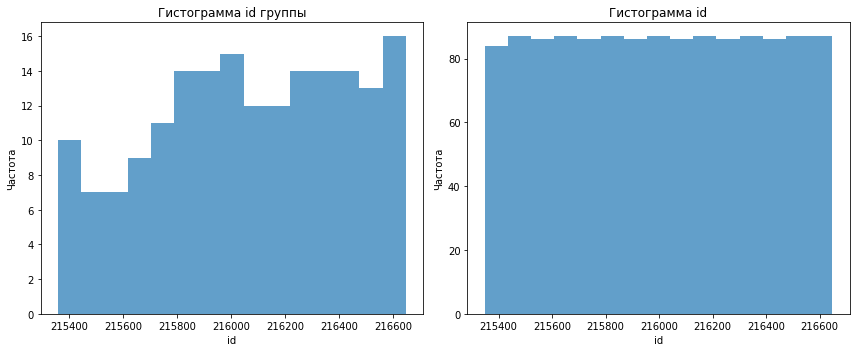

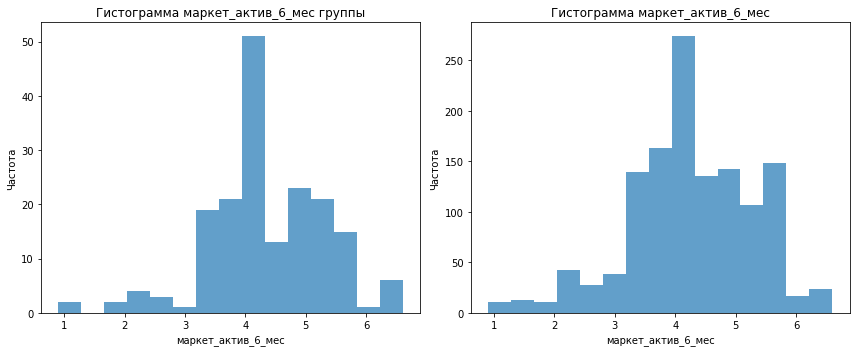

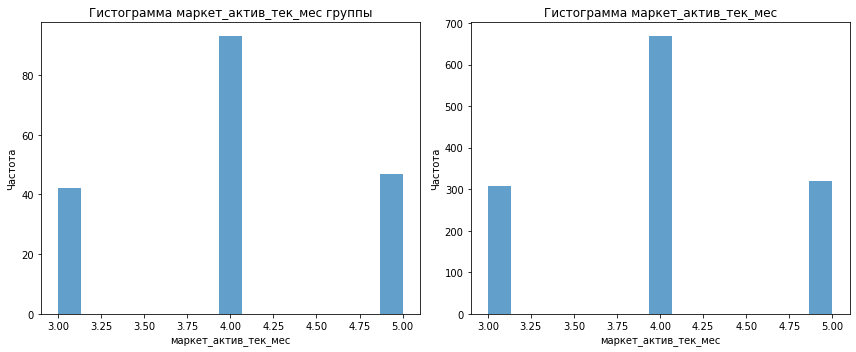

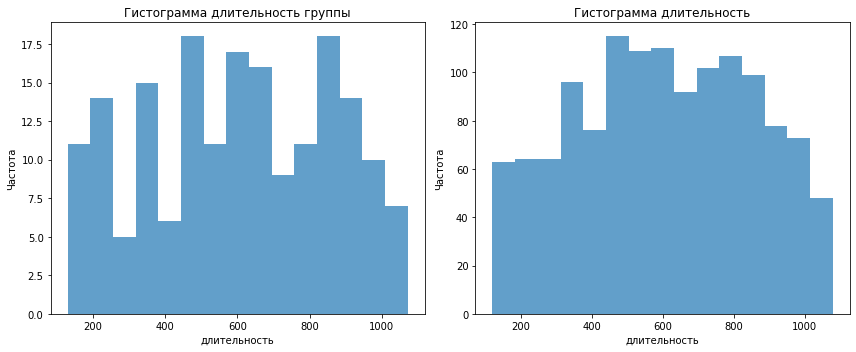

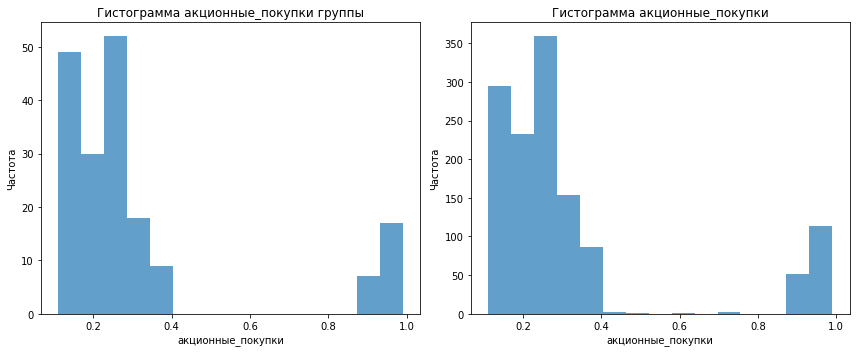

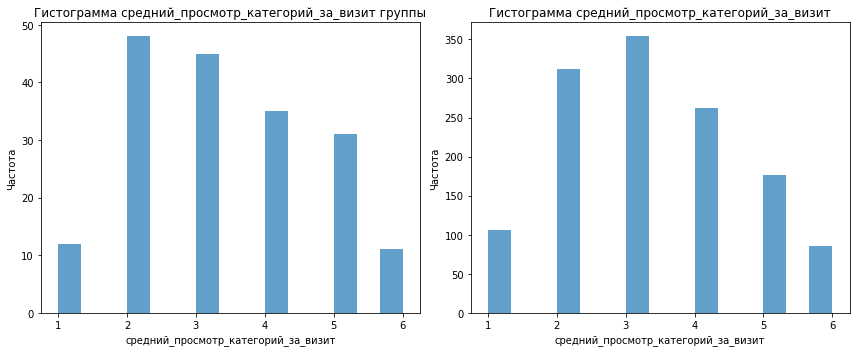

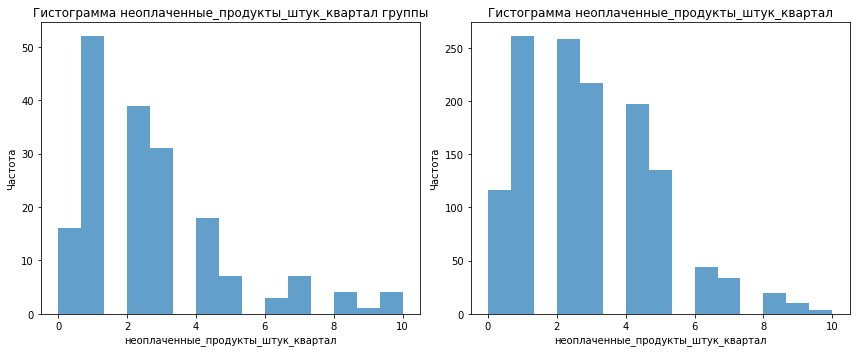

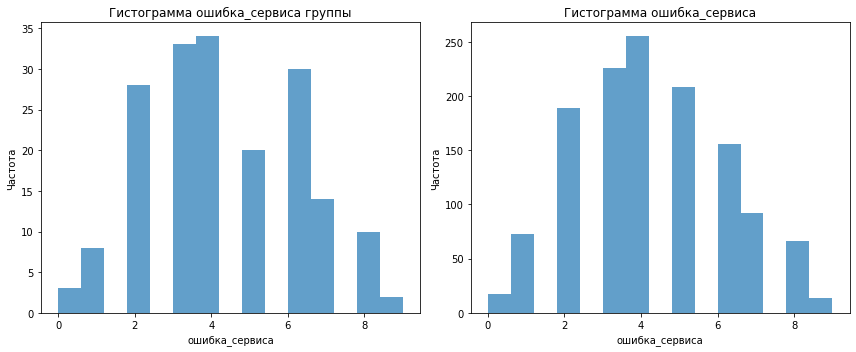

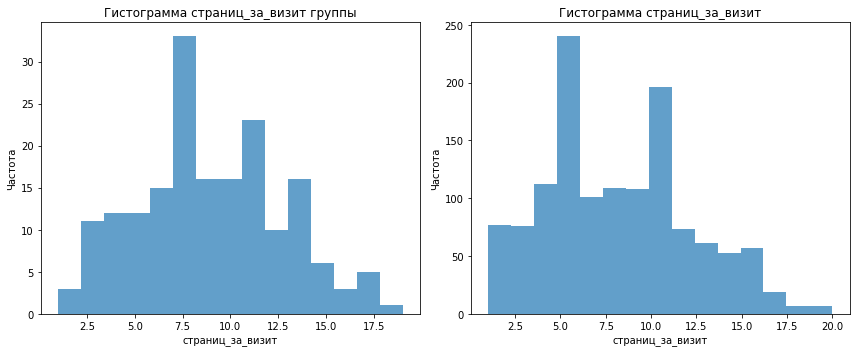

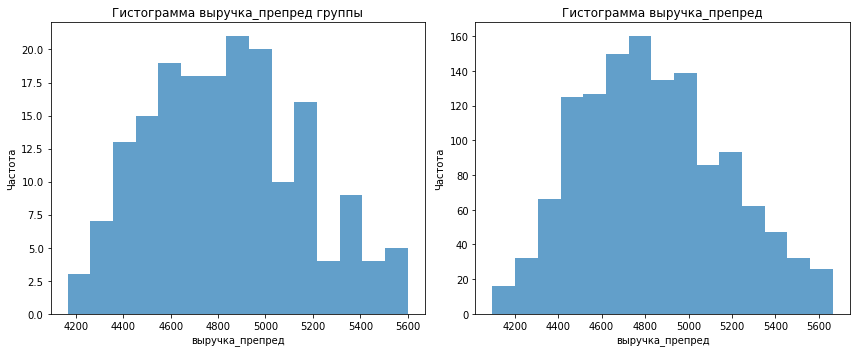

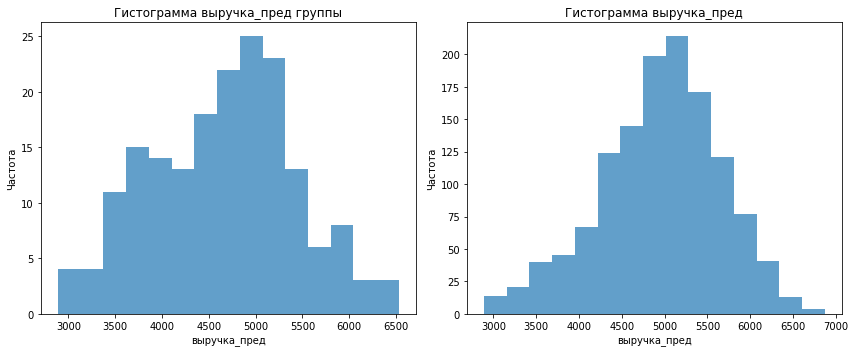

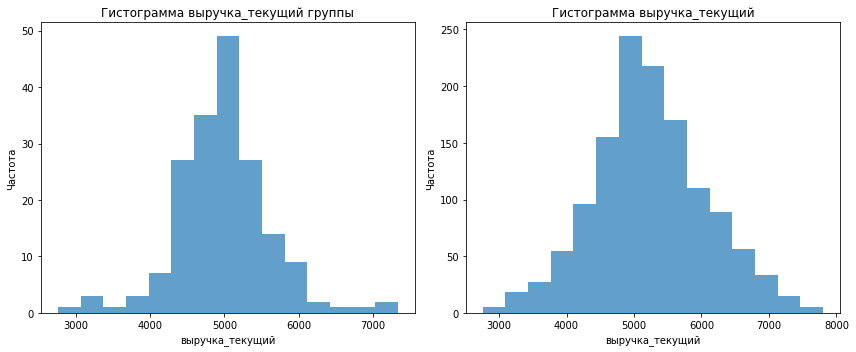

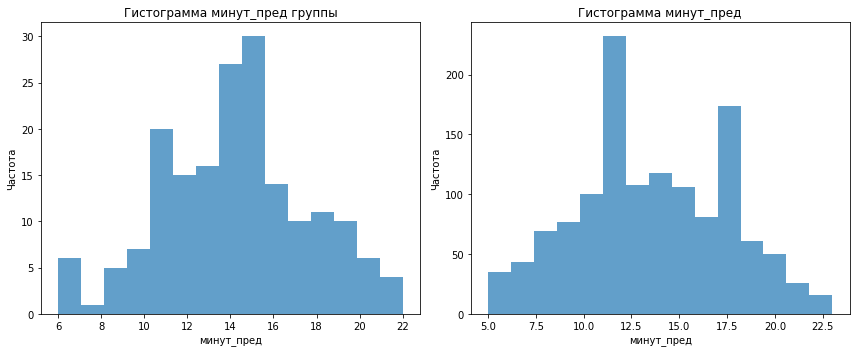

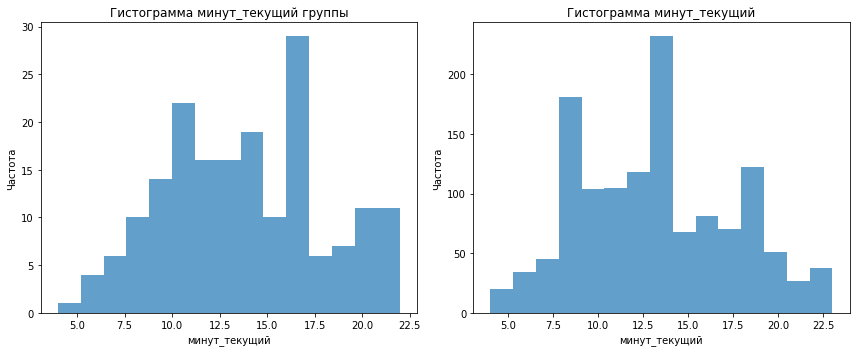

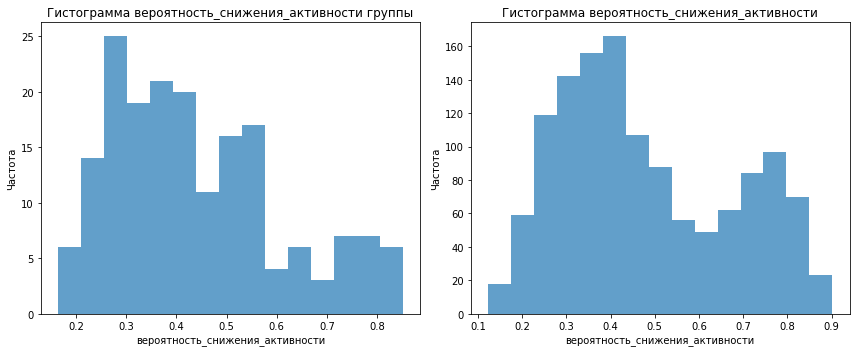

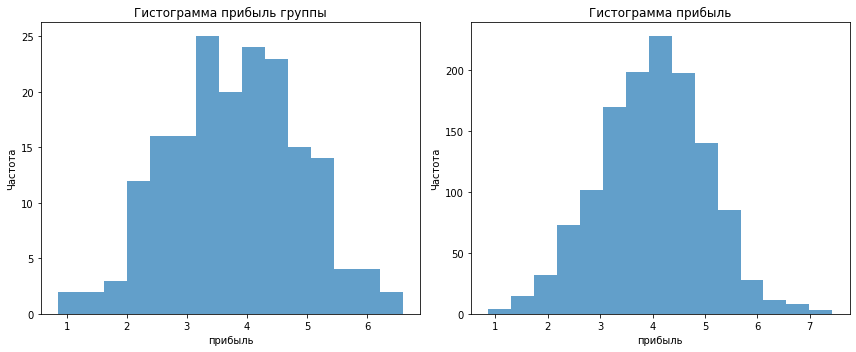

In [82]:
num_hist_group(group2, df, df_num)

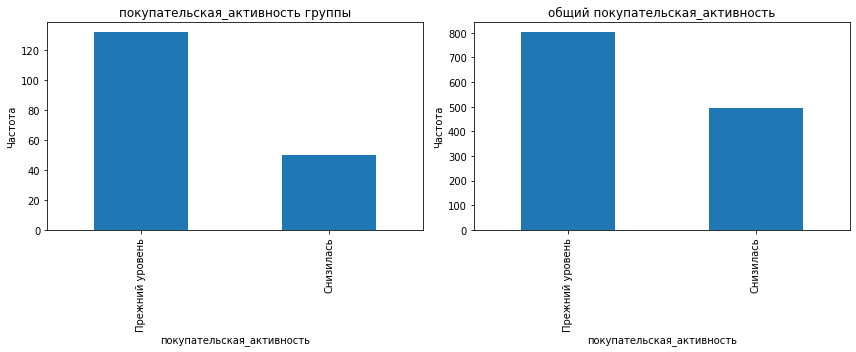

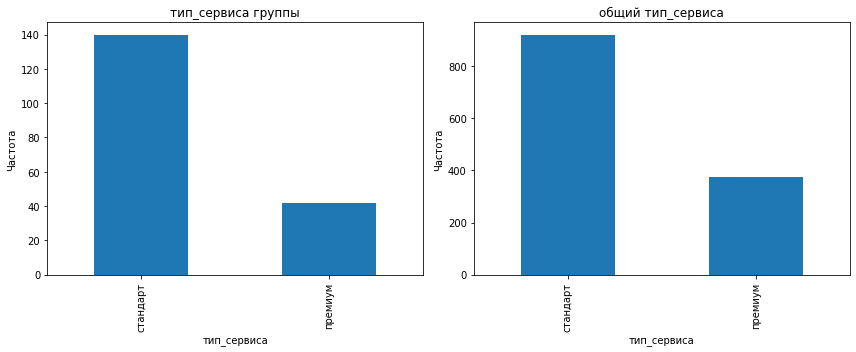

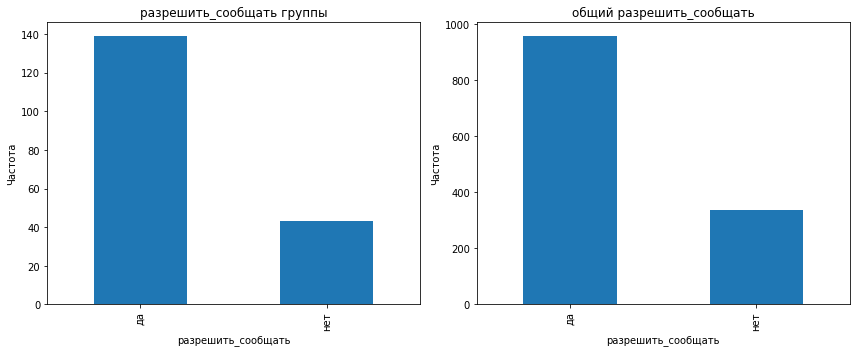

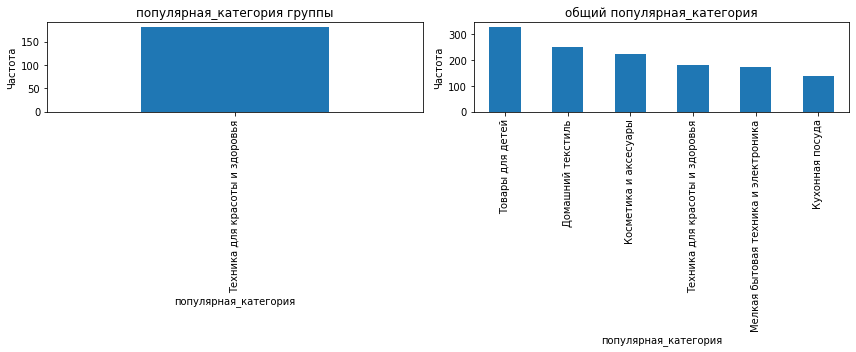

In [83]:
cat_bar(group2, df, df_cat)

Эта группа заинтересована в том, чтобы продолжать активность. Однако не так много из пользователей этой группы имеют тип сервиса "премиум". Может быть полезным продвигать этот тип.

3. Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью. Проанализируем в чем отличие  между ними и клиентами с высокой заинтересованностью

In [84]:
df['прибыль'].quantile(0.7)

4.55

In [85]:
group3 = df.query('вероятность_снижения_активности > 0.7 and прибыль >= 4.3')

In [86]:
group3_ct = df.query('вероятность_снижения_активности < 0.4 and прибыль >= 4.3')

In [87]:
group3.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препред,выручка_пред,выручка_текущий,минут_пред,минут_текущий,вероятность_снижения_активности,прибыль
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,215558.714286,3.380952,4.095238,584.914286,0.517714,2.047619,4.200000,3.809524,3.609524,4555.657143,4950.557143,5224.621905,9.228571,9.904762,0.772944,4.972095
std,119.470202,1.054942,0.686740,227.646407,0.312872,0.881225,2.229177,1.845448,1.666960,222.319712,810.412951,912.568274,2.262815,2.314352,0.051225,0.577374
min,215356.000000,0.900000,3.000000,163.000000,0.140000,1.000000,0.000000,1.000000,1.000000,4105.000000,2960.000000,3078.300000,5.000000,4.000000,0.700409,4.300000
25%,215457.000000,2.700000,4.000000,377.000000,0.270000,1.000000,2.000000,2.000000,2.000000,4410.000000,4397.000000,4458.900000,8.000000,8.000000,0.732029,4.550000
50%,215555.000000,3.500000,4.000000,616.000000,0.330000,2.000000,4.000000,3.000000,3.000000,4556.000000,5059.000000,5385.000000,9.000000,10.000000,0.765676,4.850000
75%,215649.000000,4.100000,5.000000,754.000000,0.930000,3.000000,6.000000,5.000000,5.000000,4723.000000,5567.000000,5985.500000,11.000000,11.000000,0.802950,5.160000
max,215910.000000,5.600000,5.000000,1051.000000,0.990000,5.000000,10.000000,8.000000,8.000000,5025.000000,6399.500000,6957.700000,14.000000,17.000000,0.901797,7.430000


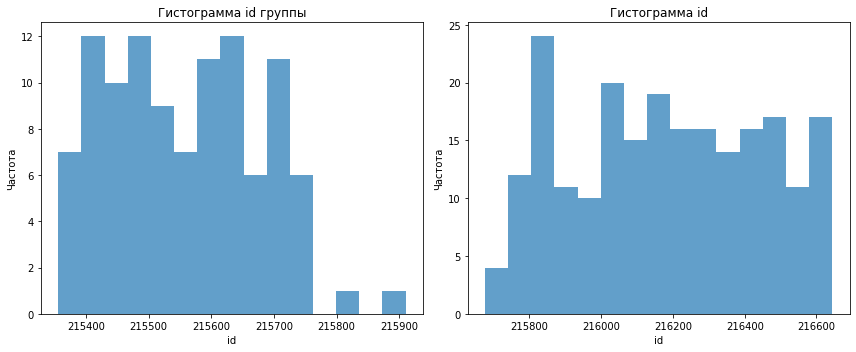

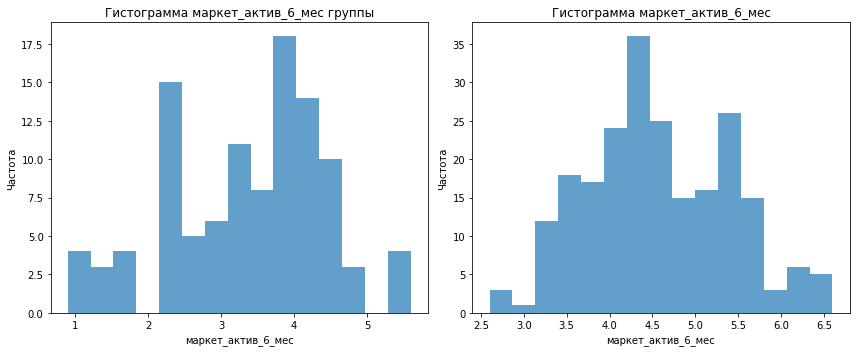

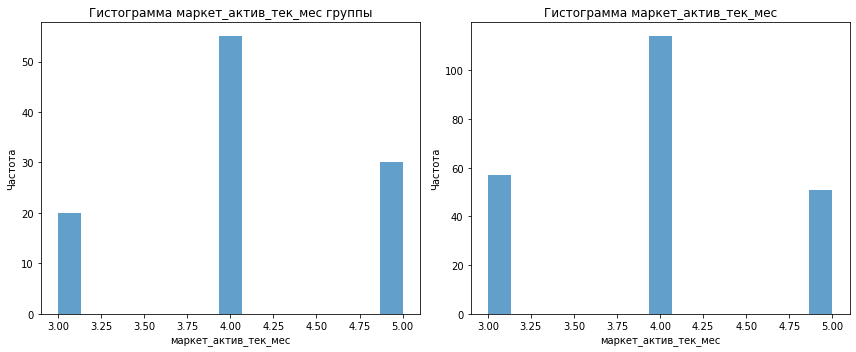

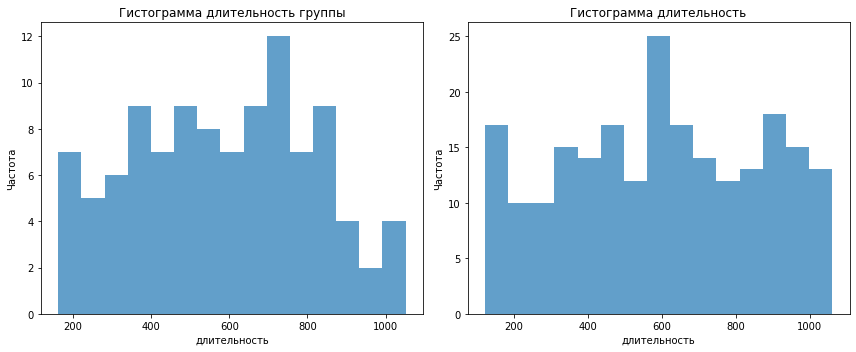

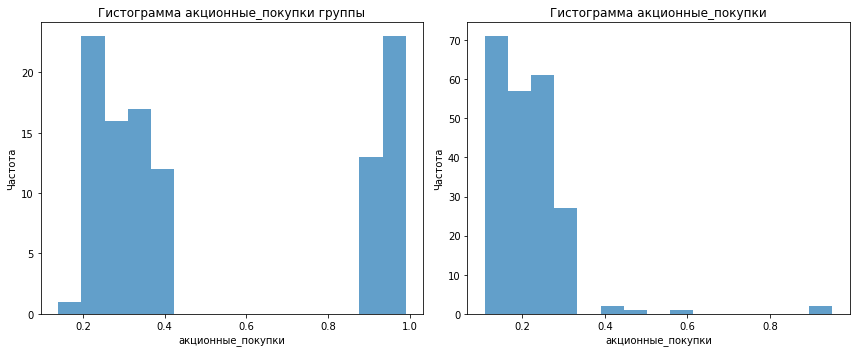

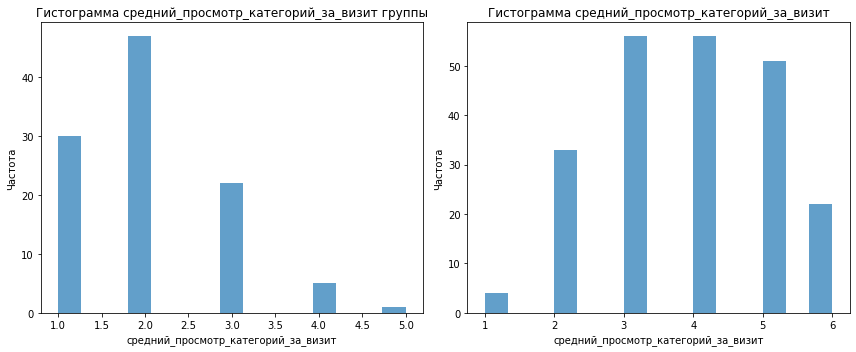

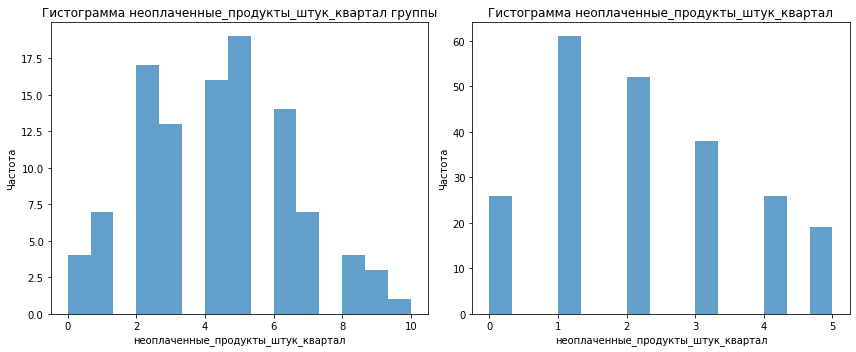

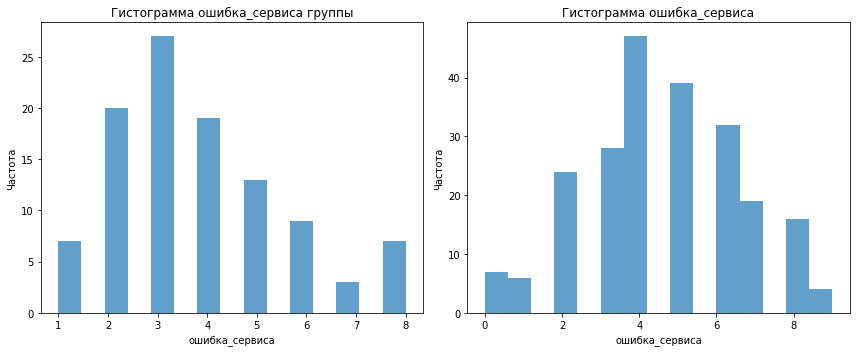

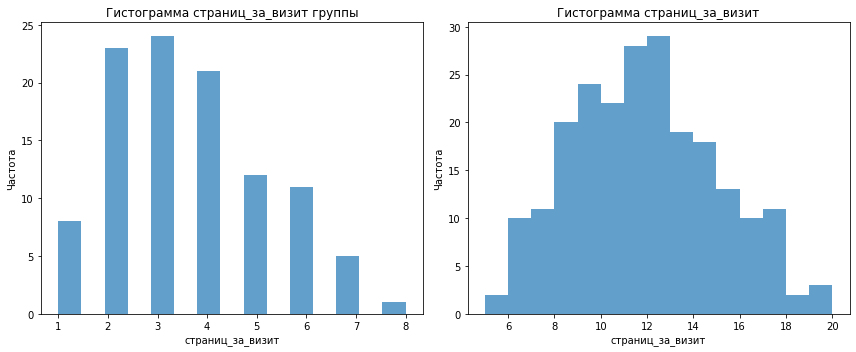

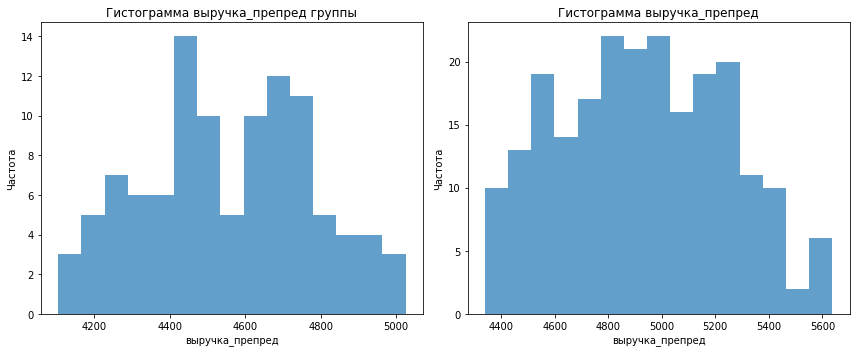

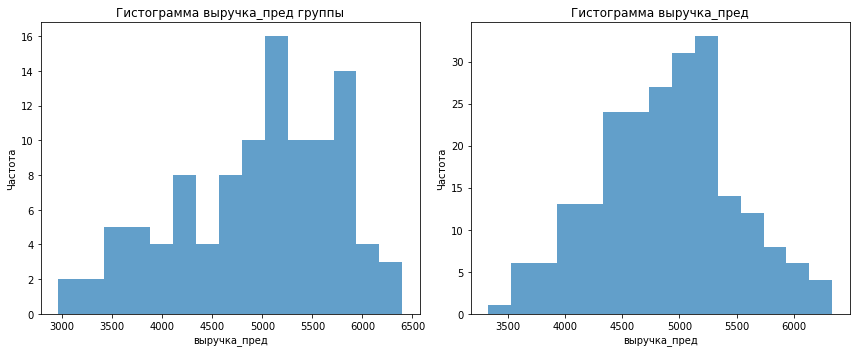

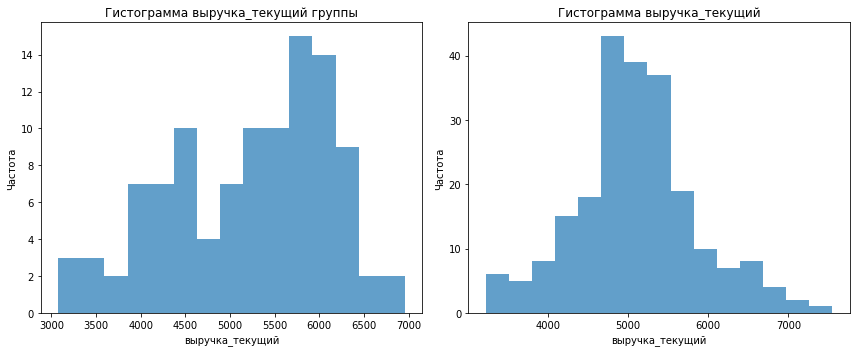

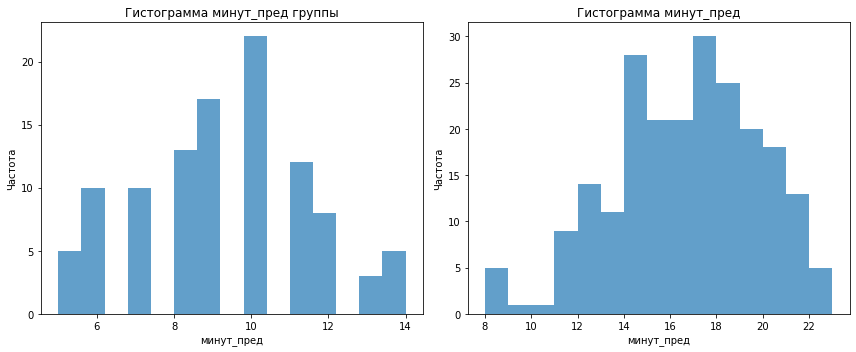

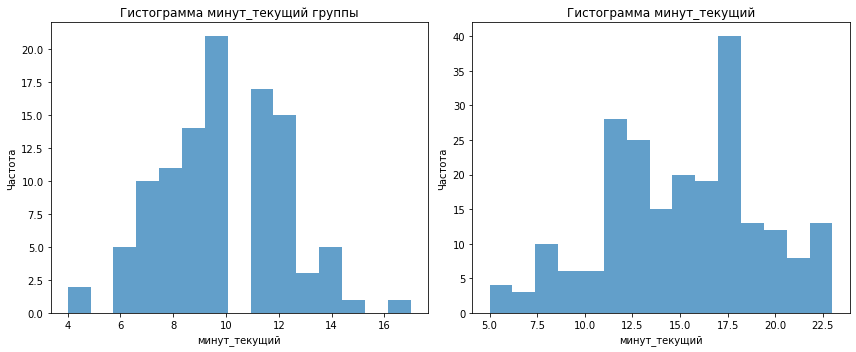

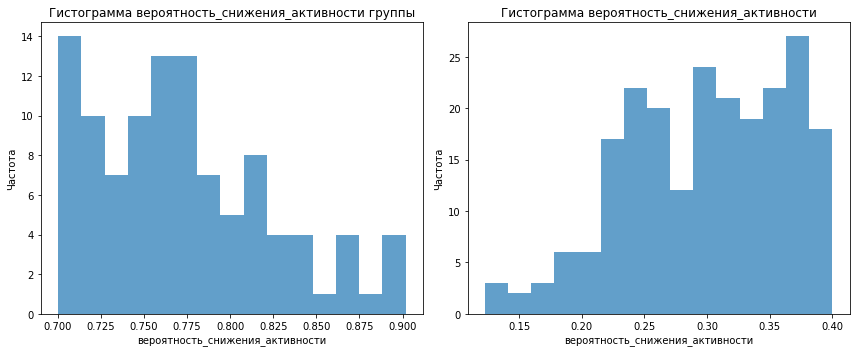

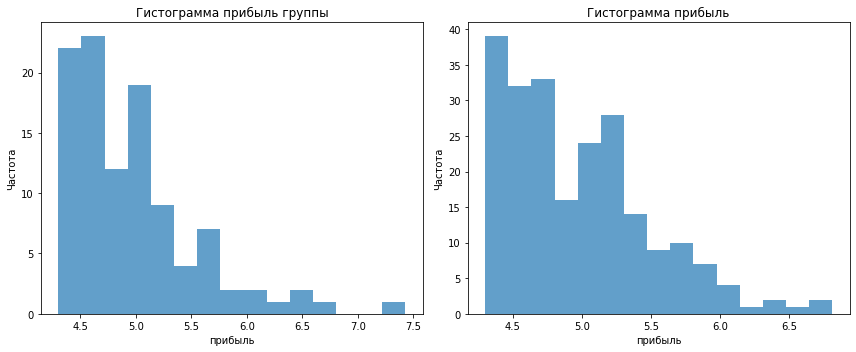

In [88]:
num_hist_group(group3, group3_ct, df_num)

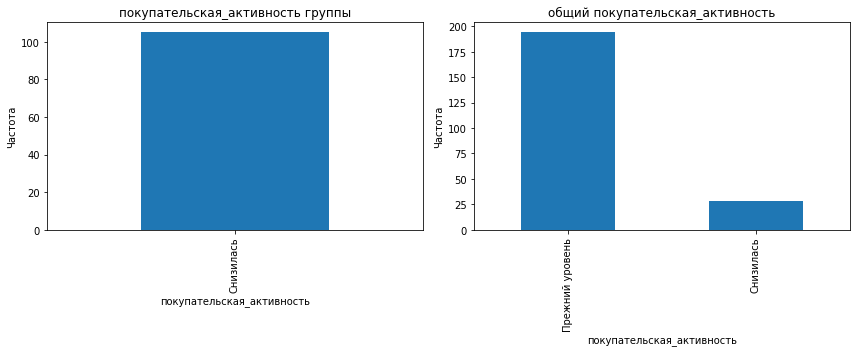

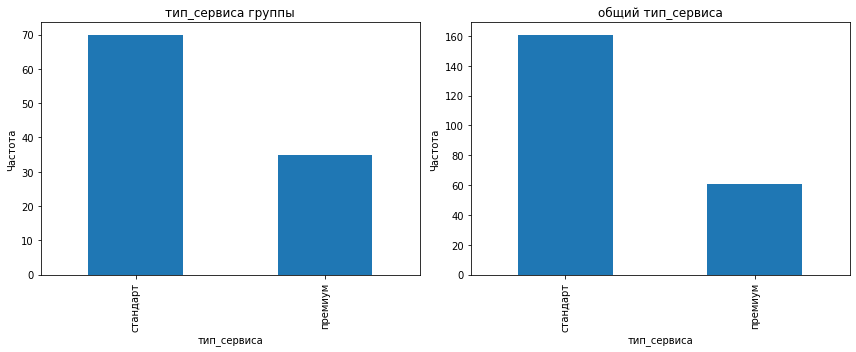

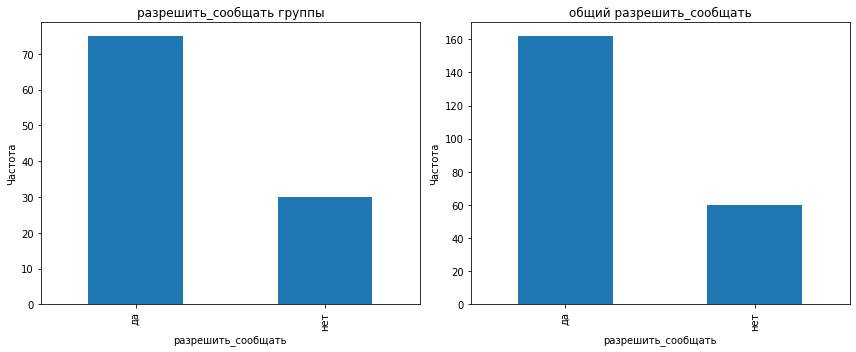

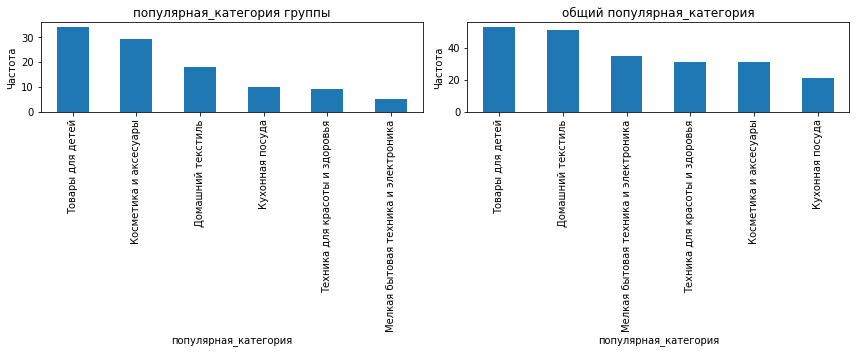

In [89]:
cat_bar_group(group3, group3_ct, df_cat)

Можно заметить, что больше всего прибыли приносят пользователи, покупающие товары для детей и косметику с аксесуарами. Пользователи этой группы также просматривают меньше товаров, посещая сайт. Вероятно, пользователи этой группы не смогли найти подходящие для них товары, либо цена их неустраивала. Следует расширить предложение в этих категориях, ведь пользователей, предпочитающих покупать домашний текстиль куда больше устраивают условия

## Общий вывод


Требовалось обучить модель, рассчитывающую вероятность снижения активности у пользователей.

Для этого в данные были добавлены новые признаки из смежных таблиц, показывающие прибыль и время пребывания на сайте в текущий и предыдущие месяцы.

Кореляционный анализ показал, что данные подходят для обучения модели.

Для того, чтобы найти подходящую модель, были перебраны модели логистической регрессии, k ближайшиз соседей, опорных векторов и дерево решений с разными параметрами регуляризации, другими гиперпараметрами и алгоритмами масштабирования данных.

Наиболее подходящей для задачи оказалась модель логистической регрессии с l1-регуляризацией и параметром C=0.01. 

После предсказаний вероятности снижения активности, пользователи были разделены по сегментам, связанных схожими значениями определенных характеристик. Был сделан вывод, что пользователей определенных групп можно привлечь более выгодными условиями продажи их любимых категорий товаров.